In [1]:
# Useful starting lines
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# Load the data

As in previous exercises, we will train a regression model to predict a person's weight from their height. The model is linear regression with one explanatory variable (weight) and an offset. The model is optimized under a least-squares loss. The variable $b$ contains the prediction targets (a vector of the length of the dataset) and the variable $A$ is the data matrix, containing (1) a column of ones and (2) a column with the explanatory variable.

In [2]:
import datetime
from helpers import *

height, weight, gender = load_data(sub_sample=False, add_outlier=False)
x, mean_x, std_x = standardize(height)
b, A = build_model_data(x, weight)

In [3]:
b.shape, A.shape

((10000,), (10000, 2))

# Least Squares Estimation
Least squares estimation is one of the fundamental machine learning algorithms. Given an $ n \times d $ matrix $A$ and a $ n \times 1$ vector $b$, the goal is to find a vector $x \in \mathbb{R}^d$ which minimizes the objective function $$f(x) = \frac{1}{2n} \sum_{i=1}^{n} (a_i^\top x - b_i)^2 = \frac{1}{2n} \|Ax - b\|^2 $$

In this exercise, we will try to fit $x$ using Least Squares Estimation. 

One can see the function is $\mu$ strongly convex with $\mu = \lambda_{max}(\nabla^2 f(x))$ and $L$ smooth with $L = \lambda_{min}(\nabla^2 f(x)$ everywhere, since here the Hessian matrix is constant, independent of $x$.



# Stochastic Gradient Descent

Please fill in the function `minibatch_gradient` below:

In [4]:
def minibatch_gradient(targets_b, data_A, params_x):
    """
    Compute a mini-batch stochastic gradient from a subset of `num_examples` from the dataset.
    
    :param targets_b: a numpy array of shape (num_examples)
    :param data_A: a numpy array of shape (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    
    :return: gradient: numpy array of shape (num_features)
    """
    batch_size = len(targets_b)
    err = targets_b - data_A.dot(params_x)
    grad = -data_A.T.dot(err) / batch_size
    return grad

Verify empirically for a fixed parameter vector $x$ that the expected value of your `minibatch_gradient` function equals the full gradient. Validating this property for a mini-batch of size 1 is sufficient.

In [5]:
num_trials = 10
for i in range(num_trials):
    # Try different parameter vectors $x$
    x = np.random.rand(A.shape[1])

    # Compute the mean of all stochastic gradient for mini-batch size 1
    stochastic_gradients = []
    for i in range(len(b)):
        stochastic_gradients.append(minibatch_gradient(b[i:i+1], A[i:i+1, :], x))

    # Compute the full gradient
    full_gradient = minibatch_gradient(b, A, x)

    # Those should be the same on average
    assert np.allclose(np.mean(stochastic_gradients, axis=0), full_gradient)
    
print('Tests passed')


Tests passed


Now, implement stochastic gradient descent for Linear Least Squares, below.


In [6]:
def stochastic_gradient(targets_b, data_A, params_x, batch_size=1):
    """
    Compute a stochastic gradient
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param params_x: compute the mini-batch gradient at these parameters, numpy array of shape (num_features)
    :param batch_size: integer: number of datapoints to compute the stochastic gradient from
    
    :return: gradient, numpy array of shape (num_features)
    """
    dataset_size = len(targets_b)
    indices = np.random.choice(dataset_size, batch_size, replace=False)
    return minibatch_gradient(targets_b[indices], data_A[indices, :], params_x)

def full_objective(targets_b, data_A, params_x):
    """Compute the least squares objective over the whole dataset"""
    return 0.5 * np.mean(((data_A @ params_x) - targets_b)**2)

def stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate, 
        decreasing_learning_rate=False):
    """
    Mini-batch Stochastic Gradient Descent for Linear Least Squares problems.
    
    :param targets_b: numpy array of size (num_examples)
    :param data_A: numpy array of size (num_examples, num_features)
    :param initial_x: starting parameters, a numpy array of size (num_features)
    :param batch_size: size of the mini-batches
    :param max_iters: integer, number of updates to do
    :param initial_learning_rate: float
    :param decreasing_learning_rate: if set to true, the learning rate should decay linearly to 0 at max_iters
    
    :return:
    - objectives, a list of loss values on the whole dataset, collected at the end of each pass over the dataset (epoch)
    - param_states, a list of parameter vectors, collected at the end of each pass over the dataset
    """
    xs = [initial_x]  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate

        # update x through the stochastic gradient update
        x = x - lr * grad

        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)
        
        print("SGD({bi:04d}/{ti:04d}): objective = {l:10.2f}".format(
              bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Now it is time to test your optimizer with a naive step size with the example code below.

In [7]:
# Define the parameters of the algorithm.
max_iters = 200
gamma = 0.2
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/0199): objective =    1967.09
SGD(0001/0199): objective =    1254.31
SGD(0002/0199): objective =     637.91
SGD(0003/0199): objective =     416.20
SGD(0004/0199): objective =     259.88
SGD(0005/0199): objective =     183.20
SGD(0006/0199): objective =     155.30
SGD(0007/0199): objective =     148.70
SGD(0008/0199): objective =     139.81
SGD(0009/0199): objective =     117.10
SGD(0010/0199): objective =     117.42
SGD(0011/0199): objective =     117.82
SGD(0012/0199): objective =     115.17
SGD(0013/0199): objective =     114.30
SGD(0014/0199): objective =      93.02
SGD(0015/0199): objective =      97.44
SGD(0016/0199): objective =      94.14
SGD(0017/0199): objective =      95.55
SGD(0018/0199): objective =      23.55
SGD(0019/0199): objective =      28.64
SGD(0020/0199): objective =      27.40
SGD(0021/0199): objective =      17.30
SGD(0022/0199): objective =      17.45
SGD(0023/0199): objective =      19.50
SGD(0024/0199): objective =      20.94
SGD(0025/0199): objective

Time Visualization

In [8]:
from plots import gradient_descent_visualization
from ipywidgets import IntSlider, interact
from grid_search import *

# Generate grid data for visualization (parameters to be swept and best combination)
grid_x0, grid_x1 = generate_w(num_intervals=10)
grid_objectives = grid_search(b, A, grid_x0, grid_x1)
loss_star, x0_star, x1_star = get_best_parameters(grid_x0, grid_x1, grid_objectives)

def plot_figure(n_iter):
    fig = gradient_descent_visualization(
        sgd_objectives, sgd_xs, grid_objectives, grid_x0, grid_x1, mean_x, std_x, height, weight, n_iter)
    fig.set_size_inches(10.0, 6.0)

interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs)))

interactive(children=(IntSlider(value=1, description='n_iter', max=201, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

# Better Learning Rate

## Assuming bounded expected stochastic gradients
Assume we are moving in a bounded region $\|x\| \leq 25$ containing all iterates (and we assume $\|x-x^\star\| \leq 25$ as well, for simplicity). By $\nabla f(x) = \frac{1}{n}A^\top (Ax - b)$, one can see that $f$ is Lipschitz over that bounded region, with Lipschitz constant $\|\nabla f(x)\| \leq \frac{1}{n} (\|A^\top A\|\|x\| + \|A^\top Ab\|)$. We also know that $E\big[\|g_t\|\big | x_t\big]\ = \nabla f(x)$. So to find B such that  $E\big[\|g_t\|^2\big]\leq B^2$, we need to compute the Lipschitz constant.

In [9]:
grad_norm_bound = (25*np.linalg.norm(np.dot(A.T,A)) + np.linalg.norm(np.dot(A.T,b)))/A.shape[0]

# Define the parameters of the algorithm.
max_iters = 200

gamma = 25 / (grad_norm_bound * np.sqrt(max_iters)) # Fill in a better learning rate  

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/0199): objective =    2690.70
SGD(0001/0199): objective =    2631.68
SGD(0002/0199): objective =    2535.40
SGD(0003/0199): objective =    2407.80
SGD(0004/0199): objective =    2353.43
SGD(0005/0199): objective =    2287.00
SGD(0006/0199): objective =    2204.32
SGD(0007/0199): objective =    2102.28
SGD(0008/0199): objective =    2027.43
SGD(0009/0199): objective =    1964.12
SGD(0010/0199): objective =    1876.91
SGD(0011/0199): objective =    1815.22
SGD(0012/0199): objective =    1759.50
SGD(0013/0199): objective =    1727.52
SGD(0014/0199): objective =    1693.13
SGD(0015/0199): objective =    1607.93
SGD(0016/0199): objective =    1585.24
SGD(0017/0199): objective =    1518.95
SGD(0018/0199): objective =    1491.56
SGD(0019/0199): objective =    1438.55
SGD(0020/0199): objective =    1406.62
SGD(0021/0199): objective =    1366.99
SGD(0022/0199): objective =    1335.78
SGD(0023/0199): objective =    1304.66
SGD(0024/0199): objective =    1281.63
SGD(0025/0199): objective

Time visualization with a better learning rate

In [10]:
interact(plot_figure, n_iter=IntSlider(min=1, max=len(sgd_xs_dec_gamma)))

interactive(children=(IntSlider(value=1, description='n_iter', max=201, min=1), Output()), _dom_classes=('widg…

<function __main__.plot_figure(n_iter)>

## SGD using strong convexity
Try doing SGD with a better learning rate using the fact that the objective function is strongly convex.<br>
(Hint: you can use a decreasing stepsize parameter gamma in stochastic_gradient_descent.)

In [11]:
# Define the parameters of the algorithm.
max_iters = 200

# You may use these results from last week
mu = np.linalg.norm(A, -2)**2 / len(A)
L = np.linalg.norm(A, 2)**2 / len(A)

gamma0 = 2 / mu
batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma0, decreasing_learning_rate=True)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/0199): objective =    5872.65
SGD(0001/0199): objective =    3481.06
SGD(0002/0199): objective =    1181.67
SGD(0003/0199): objective =     211.03
SGD(0004/0199): objective =     157.39
SGD(0005/0199): objective =     168.11
SGD(0006/0199): objective =     173.15
SGD(0007/0199): objective =     159.95
SGD(0008/0199): objective =      18.82
SGD(0009/0199): objective =      17.12
SGD(0010/0199): objective =      16.90
SGD(0011/0199): objective =      18.07
SGD(0012/0199): objective =      17.66
SGD(0013/0199): objective =      17.07
SGD(0014/0199): objective =      16.95
SGD(0015/0199): objective =      17.02
SGD(0016/0199): objective =      17.81
SGD(0017/0199): objective =      15.64
SGD(0018/0199): objective =      15.51
SGD(0019/0199): objective =      15.41
SGD(0020/0199): objective =      15.40
SGD(0021/0199): objective =      15.41
SGD(0022/0199): objective =      15.62
SGD(0023/0199): objective =      15.89
SGD(0024/0199): objective =      15.52
SGD(0025/0199): objective

## Evolution of the objective function

Make sure to copy your code for the gradient descent implementation from lab03 into the file gradient_descent.py

Run the following code to compare SGD (with diffent stepsizes) and gradient descent with respect to the number of gradient computations needed per iteration (remember that gradient descent computes n gradients per iterations)

In [14]:
from gradient_descent import gradient_descent
x_initial = np.zeros(A.shape[1])
gradient_objectives, gradient_xs = gradient_descent(b, A, x_initial, 3, 1/L)

sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, 0.2)
sgd_objectives_dec_gamma, sgd_xs_dec_gamma = stochastic_gradient_descent(
    b, A, x_initial, 1, 20000, #fill in the learning rate used above#,
    decreasing_gamma = True)

Gradient Descent(0/2): objective=2792.2367127591674
Gradient Descent(1/2): objective=15.3858878688294
Gradient Descent(2/2): objective=15.3858878688294
SGD(0000/19999): objective =    2137.58
SGD(0001/19999): objective =     920.15
SGD(0002/19999): objective =     582.96
SGD(0003/19999): objective =     443.63
SGD(0004/19999): objective =     440.81
SGD(0005/19999): objective =     441.50
SGD(0006/19999): objective =     371.60
SGD(0007/19999): objective =     135.78
SGD(0008/19999): objective =     128.47
SGD(0009/19999): objective =     128.91
SGD(0010/19999): objective =     109.96
SGD(0011/19999): objective =      54.82
SGD(0012/19999): objective =      57.01
SGD(0013/19999): objective =      53.26
SGD(0014/19999): objective =      49.53
SGD(0015/19999): objective =      50.86
SGD(0016/19999): objective =      23.83
SGD(0017/19999): objective =      18.90
SGD(0018/19999): objective =      15.76
SGD(0019/19999): objective =      15.68
SGD(0020/19999): objective =      18.79
SGD(0021

SGD(0320/19999): objective =      16.47
SGD(0321/19999): objective =      16.72
SGD(0322/19999): objective =      15.93
SGD(0323/19999): objective =      15.64
SGD(0324/19999): objective =      15.51
SGD(0325/19999): objective =      15.57
SGD(0326/19999): objective =      16.74
SGD(0327/19999): objective =      17.01
SGD(0328/19999): objective =      15.64
SGD(0329/19999): objective =      15.74
SGD(0330/19999): objective =      18.74
SGD(0331/19999): objective =      19.12
SGD(0332/19999): objective =      19.88
SGD(0333/19999): objective =      19.22
SGD(0334/19999): objective =      17.99
SGD(0335/19999): objective =      28.67
SGD(0336/19999): objective =      16.81
SGD(0337/19999): objective =      19.10
SGD(0338/19999): objective =      20.21
SGD(0339/19999): objective =      17.60
SGD(0340/19999): objective =      17.73
SGD(0341/19999): objective =      15.99
SGD(0342/19999): objective =      16.33
SGD(0343/19999): objective =      15.74
SGD(0344/19999): objective =      15.84


SGD(0646/19999): objective =      18.75
SGD(0647/19999): objective =      21.15
SGD(0648/19999): objective =      17.62
SGD(0649/19999): objective =      18.69
SGD(0650/19999): objective =      19.08
SGD(0651/19999): objective =      18.01
SGD(0652/19999): objective =      21.33
SGD(0653/19999): objective =      21.87
SGD(0654/19999): objective =      20.17
SGD(0655/19999): objective =      22.92
SGD(0656/19999): objective =      19.49
SGD(0657/19999): objective =      23.78
SGD(0658/19999): objective =      19.84
SGD(0659/19999): objective =      16.38
SGD(0660/19999): objective =      16.39
SGD(0661/19999): objective =      16.15
SGD(0662/19999): objective =      21.59
SGD(0663/19999): objective =      16.34
SGD(0664/19999): objective =      24.12
SGD(0665/19999): objective =      22.87
SGD(0666/19999): objective =      21.88
SGD(0667/19999): objective =      22.73
SGD(0668/19999): objective =      21.48
SGD(0669/19999): objective =      21.52
SGD(0670/19999): objective =      15.64


SGD(0937/19999): objective =      19.81
SGD(0938/19999): objective =      20.17
SGD(0939/19999): objective =      17.18
SGD(0940/19999): objective =      17.56
SGD(0941/19999): objective =      17.72
SGD(0942/19999): objective =      20.81
SGD(0943/19999): objective =      18.47
SGD(0944/19999): objective =      15.68
SGD(0945/19999): objective =      15.98
SGD(0946/19999): objective =      16.21
SGD(0947/19999): objective =      16.24
SGD(0948/19999): objective =      16.32
SGD(0949/19999): objective =      16.18
SGD(0950/19999): objective =      19.95
SGD(0951/19999): objective =      19.73
SGD(0952/19999): objective =      20.32
SGD(0953/19999): objective =      27.69
SGD(0954/19999): objective =      32.76
SGD(0955/19999): objective =      27.40
SGD(0956/19999): objective =      24.60
SGD(0957/19999): objective =      29.68
SGD(0958/19999): objective =      28.35
SGD(0959/19999): objective =      25.72
SGD(0960/19999): objective =      22.98
SGD(0961/19999): objective =      20.38


SGD(1273/19999): objective =      19.18
SGD(1274/19999): objective =      17.67
SGD(1275/19999): objective =      17.84
SGD(1276/19999): objective =      16.71
SGD(1277/19999): objective =      19.18
SGD(1278/19999): objective =      19.49
SGD(1279/19999): objective =      18.91
SGD(1280/19999): objective =      18.54
SGD(1281/19999): objective =      16.17
SGD(1282/19999): objective =      16.23
SGD(1283/19999): objective =      20.31
SGD(1284/19999): objective =      21.73
SGD(1285/19999): objective =      25.46
SGD(1286/19999): objective =      23.85
SGD(1287/19999): objective =      21.31
SGD(1288/19999): objective =      19.12
SGD(1289/19999): objective =      19.30
SGD(1290/19999): objective =      21.02
SGD(1291/19999): objective =      18.59
SGD(1292/19999): objective =      18.12
SGD(1293/19999): objective =      16.59
SGD(1294/19999): objective =      15.87
SGD(1295/19999): objective =      15.71
SGD(1296/19999): objective =      18.82
SGD(1297/19999): objective =      19.48


SGD(1601/19999): objective =      19.33
SGD(1602/19999): objective =      17.48
SGD(1603/19999): objective =      16.73
SGD(1604/19999): objective =      15.74
SGD(1605/19999): objective =      21.26
SGD(1606/19999): objective =      16.11
SGD(1607/19999): objective =      15.66
SGD(1608/19999): objective =      15.59
SGD(1609/19999): objective =      16.48
SGD(1610/19999): objective =      19.15
SGD(1611/19999): objective =      18.96
SGD(1612/19999): objective =      15.96
SGD(1613/19999): objective =      15.72
SGD(1614/19999): objective =      15.65
SGD(1615/19999): objective =      15.45
SGD(1616/19999): objective =      15.63
SGD(1617/19999): objective =      17.54
SGD(1618/19999): objective =      15.65
SGD(1619/19999): objective =      15.51
SGD(1620/19999): objective =      17.18
SGD(1621/19999): objective =      15.41
SGD(1622/19999): objective =      17.06
SGD(1623/19999): objective =      15.47
SGD(1624/19999): objective =      15.80
SGD(1625/19999): objective =      17.17


SGD(1933/19999): objective =      22.27
SGD(1934/19999): objective =      22.02
SGD(1935/19999): objective =      15.46
SGD(1936/19999): objective =      15.76
SGD(1937/19999): objective =      16.10
SGD(1938/19999): objective =      16.74
SGD(1939/19999): objective =      17.20
SGD(1940/19999): objective =      17.46
SGD(1941/19999): objective =      16.22
SGD(1942/19999): objective =      16.13
SGD(1943/19999): objective =      16.55
SGD(1944/19999): objective =      15.45
SGD(1945/19999): objective =      15.43
SGD(1946/19999): objective =      15.66
SGD(1947/19999): objective =      15.42
SGD(1948/19999): objective =      15.83
SGD(1949/19999): objective =      15.76
SGD(1950/19999): objective =      16.03
SGD(1951/19999): objective =      16.42
SGD(1952/19999): objective =      16.43
SGD(1953/19999): objective =      16.30
SGD(1954/19999): objective =      15.63
SGD(1955/19999): objective =      15.54
SGD(1956/19999): objective =      15.99
SGD(1957/19999): objective =      15.55


SGD(2264/19999): objective =      15.62
SGD(2265/19999): objective =      15.75
SGD(2266/19999): objective =      15.42
SGD(2267/19999): objective =      15.77
SGD(2268/19999): objective =      16.19
SGD(2269/19999): objective =      15.59
SGD(2270/19999): objective =      15.44
SGD(2271/19999): objective =      15.64
SGD(2272/19999): objective =      16.62
SGD(2273/19999): objective =      17.29
SGD(2274/19999): objective =      17.09
SGD(2275/19999): objective =      17.86
SGD(2276/19999): objective =      18.84
SGD(2277/19999): objective =      18.41
SGD(2278/19999): objective =      18.22
SGD(2279/19999): objective =      20.50
SGD(2280/19999): objective =      23.07
SGD(2281/19999): objective =      21.77
SGD(2282/19999): objective =      20.77
SGD(2283/19999): objective =      20.49
SGD(2284/19999): objective =      20.14
SGD(2285/19999): objective =      22.09
SGD(2286/19999): objective =      23.34
SGD(2287/19999): objective =      20.22
SGD(2288/19999): objective =      20.07


SGD(2608/19999): objective =      21.38
SGD(2609/19999): objective =      20.81
SGD(2610/19999): objective =      20.49
SGD(2611/19999): objective =      20.86
SGD(2612/19999): objective =      21.80
SGD(2613/19999): objective =      19.89
SGD(2614/19999): objective =      22.80
SGD(2615/19999): objective =      15.77
SGD(2616/19999): objective =      16.71
SGD(2617/19999): objective =      17.45
SGD(2618/19999): objective =      18.16
SGD(2619/19999): objective =      19.33
SGD(2620/19999): objective =      16.84
SGD(2621/19999): objective =      15.40
SGD(2622/19999): objective =      15.41
SGD(2623/19999): objective =      16.15
SGD(2624/19999): objective =      16.82
SGD(2625/19999): objective =      16.76
SGD(2626/19999): objective =      15.64
SGD(2627/19999): objective =      15.42
SGD(2628/19999): objective =      15.42
SGD(2629/19999): objective =      15.56
SGD(2630/19999): objective =      15.58
SGD(2631/19999): objective =      16.53
SGD(2632/19999): objective =      17.76


SGD(2937/19999): objective =      15.93
SGD(2938/19999): objective =      17.40
SGD(2939/19999): objective =      17.57
SGD(2940/19999): objective =      17.09
SGD(2941/19999): objective =      17.38
SGD(2942/19999): objective =      18.34
SGD(2943/19999): objective =      16.56
SGD(2944/19999): objective =      16.05
SGD(2945/19999): objective =      19.27
SGD(2946/19999): objective =      20.30
SGD(2947/19999): objective =      20.02
SGD(2948/19999): objective =      21.63
SGD(2949/19999): objective =      15.98
SGD(2950/19999): objective =      17.78
SGD(2951/19999): objective =      17.71
SGD(2952/19999): objective =      17.51
SGD(2953/19999): objective =      15.68
SGD(2954/19999): objective =      15.50
SGD(2955/19999): objective =      15.51
SGD(2956/19999): objective =      16.22
SGD(2957/19999): objective =      16.88
SGD(2958/19999): objective =      19.43
SGD(2959/19999): objective =      19.67
SGD(2960/19999): objective =      17.00
SGD(2961/19999): objective =      20.91


SGD(3253/19999): objective =      27.26
SGD(3254/19999): objective =      26.69
SGD(3255/19999): objective =      25.17
SGD(3256/19999): objective =      25.46
SGD(3257/19999): objective =      26.78
SGD(3258/19999): objective =      22.60
SGD(3259/19999): objective =      20.56
SGD(3260/19999): objective =      19.64
SGD(3261/19999): objective =      18.92
SGD(3262/19999): objective =      18.03
SGD(3263/19999): objective =      24.61
SGD(3264/19999): objective =      22.04
SGD(3265/19999): objective =      26.28
SGD(3266/19999): objective =      17.30
SGD(3267/19999): objective =      16.81
SGD(3268/19999): objective =      16.20
SGD(3269/19999): objective =      15.79
SGD(3270/19999): objective =      15.70
SGD(3271/19999): objective =      16.11
SGD(3272/19999): objective =      15.87
SGD(3273/19999): objective =      16.08
SGD(3274/19999): objective =      18.69
SGD(3275/19999): objective =      16.02
SGD(3276/19999): objective =      16.62
SGD(3277/19999): objective =      17.10


SGD(3526/19999): objective =      16.37
SGD(3527/19999): objective =      18.84
SGD(3528/19999): objective =      18.83
SGD(3529/19999): objective =      16.18
SGD(3530/19999): objective =      15.51
SGD(3531/19999): objective =      15.51
SGD(3532/19999): objective =      15.44
SGD(3533/19999): objective =      16.96
SGD(3534/19999): objective =      18.87
SGD(3535/19999): objective =      18.16
SGD(3536/19999): objective =      17.99
SGD(3537/19999): objective =      17.03
SGD(3538/19999): objective =      16.05
SGD(3539/19999): objective =      16.22
SGD(3540/19999): objective =      16.00
SGD(3541/19999): objective =      16.43
SGD(3542/19999): objective =      16.37
SGD(3543/19999): objective =      16.51
SGD(3544/19999): objective =      16.71
SGD(3545/19999): objective =      15.71
SGD(3546/19999): objective =      16.10
SGD(3547/19999): objective =      16.76
SGD(3548/19999): objective =      15.70
SGD(3549/19999): objective =      22.44
SGD(3550/19999): objective =      21.29


SGD(3801/19999): objective =      17.26
SGD(3802/19999): objective =      17.15
SGD(3803/19999): objective =      16.69
SGD(3804/19999): objective =      16.49
SGD(3805/19999): objective =      22.89
SGD(3806/19999): objective =      25.14
SGD(3807/19999): objective =      34.28
SGD(3808/19999): objective =      36.22
SGD(3809/19999): objective =      24.58
SGD(3810/19999): objective =      22.01
SGD(3811/19999): objective =      19.22
SGD(3812/19999): objective =      20.87
SGD(3813/19999): objective =      21.09
SGD(3814/19999): objective =      23.68
SGD(3815/19999): objective =      23.81
SGD(3816/19999): objective =      29.47
SGD(3817/19999): objective =      31.88
SGD(3818/19999): objective =      19.83
SGD(3819/19999): objective =      21.38
SGD(3820/19999): objective =      19.31
SGD(3821/19999): objective =      20.36
SGD(3822/19999): objective =      19.26
SGD(3823/19999): objective =      16.20
SGD(3824/19999): objective =      19.29
SGD(3825/19999): objective =      18.71


SGD(4063/19999): objective =      15.51
SGD(4064/19999): objective =      16.63
SGD(4065/19999): objective =      16.64
SGD(4066/19999): objective =      15.80
SGD(4067/19999): objective =      15.84
SGD(4068/19999): objective =      16.32
SGD(4069/19999): objective =      18.33
SGD(4070/19999): objective =      15.72
SGD(4071/19999): objective =      15.64
SGD(4072/19999): objective =      15.98
SGD(4073/19999): objective =      16.55
SGD(4074/19999): objective =      17.90
SGD(4075/19999): objective =      17.33
SGD(4076/19999): objective =      18.63
SGD(4077/19999): objective =      16.22
SGD(4078/19999): objective =      16.12
SGD(4079/19999): objective =      15.61
SGD(4080/19999): objective =      15.47
SGD(4081/19999): objective =      16.36
SGD(4082/19999): objective =      16.79
SGD(4083/19999): objective =      16.37
SGD(4084/19999): objective =      16.39
SGD(4085/19999): objective =      16.54
SGD(4086/19999): objective =      15.65
SGD(4087/19999): objective =      15.61


SGD(4305/19999): objective =      15.45
SGD(4306/19999): objective =      15.81
SGD(4307/19999): objective =      20.39
SGD(4308/19999): objective =      16.21
SGD(4309/19999): objective =      16.08
SGD(4310/19999): objective =      18.47
SGD(4311/19999): objective =      17.29
SGD(4312/19999): objective =      22.64
SGD(4313/19999): objective =      23.54
SGD(4314/19999): objective =      26.93
SGD(4315/19999): objective =      18.71
SGD(4316/19999): objective =      20.02
SGD(4317/19999): objective =      18.97
SGD(4318/19999): objective =      15.78
SGD(4319/19999): objective =      16.44
SGD(4320/19999): objective =      17.76
SGD(4321/19999): objective =      18.47
SGD(4322/19999): objective =      18.98
SGD(4323/19999): objective =      17.90
SGD(4324/19999): objective =      17.69
SGD(4325/19999): objective =      15.76
SGD(4326/19999): objective =      15.94
SGD(4327/19999): objective =      16.12
SGD(4328/19999): objective =      16.21
SGD(4329/19999): objective =      17.44


SGD(4647/19999): objective =      18.41
SGD(4648/19999): objective =      16.81
SGD(4649/19999): objective =      18.14
SGD(4650/19999): objective =      18.61
SGD(4651/19999): objective =      18.65
SGD(4652/19999): objective =      18.32
SGD(4653/19999): objective =      18.26
SGD(4654/19999): objective =      17.53
SGD(4655/19999): objective =      15.95
SGD(4656/19999): objective =      27.06
SGD(4657/19999): objective =      25.77
SGD(4658/19999): objective =      19.68
SGD(4659/19999): objective =      17.02
SGD(4660/19999): objective =      16.66
SGD(4661/19999): objective =      15.89
SGD(4662/19999): objective =      15.83
SGD(4663/19999): objective =      15.71
SGD(4664/19999): objective =      15.96
SGD(4665/19999): objective =      18.97
SGD(4666/19999): objective =      18.86
SGD(4667/19999): objective =      17.32
SGD(4668/19999): objective =      21.15
SGD(4669/19999): objective =      17.03
SGD(4670/19999): objective =      16.78
SGD(4671/19999): objective =      24.19


SGD(4878/19999): objective =      28.37
SGD(4879/19999): objective =      29.01
SGD(4880/19999): objective =      22.07
SGD(4881/19999): objective =      21.45
SGD(4882/19999): objective =      21.84
SGD(4883/19999): objective =      21.04
SGD(4884/19999): objective =      18.95
SGD(4885/19999): objective =      21.01
SGD(4886/19999): objective =      19.58
SGD(4887/19999): objective =      19.27
SGD(4888/19999): objective =      15.88
SGD(4889/19999): objective =      16.76
SGD(4890/19999): objective =      19.33
SGD(4891/19999): objective =      18.86
SGD(4892/19999): objective =      20.13
SGD(4893/19999): objective =      22.50
SGD(4894/19999): objective =      26.59
SGD(4895/19999): objective =      30.29
SGD(4896/19999): objective =      24.92
SGD(4897/19999): objective =      24.75
SGD(4898/19999): objective =      19.79
SGD(4899/19999): objective =      16.97
SGD(4900/19999): objective =      16.93
SGD(4901/19999): objective =      16.26
SGD(4902/19999): objective =      17.27


SGD(5237/19999): objective =      16.16
SGD(5238/19999): objective =      17.00
SGD(5239/19999): objective =      19.31
SGD(5240/19999): objective =      24.44
SGD(5241/19999): objective =      24.94
SGD(5242/19999): objective =      25.99
SGD(5243/19999): objective =      21.27
SGD(5244/19999): objective =      20.05
SGD(5245/19999): objective =      17.81
SGD(5246/19999): objective =      17.82
SGD(5247/19999): objective =      19.35
SGD(5248/19999): objective =      18.39
SGD(5249/19999): objective =      19.25
SGD(5250/19999): objective =      16.01
SGD(5251/19999): objective =      15.67
SGD(5252/19999): objective =      18.50
SGD(5253/19999): objective =      18.45
SGD(5254/19999): objective =      16.53
SGD(5255/19999): objective =      15.43
SGD(5256/19999): objective =      15.62
SGD(5257/19999): objective =      15.47
SGD(5258/19999): objective =      15.47
SGD(5259/19999): objective =      15.57
SGD(5260/19999): objective =      15.44
SGD(5261/19999): objective =      15.52


SGD(5580/19999): objective =      24.12
SGD(5581/19999): objective =      22.70
SGD(5582/19999): objective =      23.65
SGD(5583/19999): objective =      22.04
SGD(5584/19999): objective =      20.77
SGD(5585/19999): objective =      18.78
SGD(5586/19999): objective =      20.54
SGD(5587/19999): objective =      25.74
SGD(5588/19999): objective =      28.07
SGD(5589/19999): objective =      28.06
SGD(5590/19999): objective =      28.99
SGD(5591/19999): objective =      28.13
SGD(5592/19999): objective =      28.43
SGD(5593/19999): objective =      32.37
SGD(5594/19999): objective =      32.23
SGD(5595/19999): objective =      33.86
SGD(5596/19999): objective =      21.79
SGD(5597/19999): objective =      21.68
SGD(5598/19999): objective =      16.42
SGD(5599/19999): objective =      17.29
SGD(5600/19999): objective =      19.16
SGD(5601/19999): objective =      25.95
SGD(5602/19999): objective =      25.60
SGD(5603/19999): objective =      25.39
SGD(5604/19999): objective =      19.41


SGD(5854/19999): objective =      16.74
SGD(5855/19999): objective =      18.28
SGD(5856/19999): objective =      18.09
SGD(5857/19999): objective =      20.16
SGD(5858/19999): objective =      33.62
SGD(5859/19999): objective =      34.09
SGD(5860/19999): objective =      24.37
SGD(5861/19999): objective =      23.70
SGD(5862/19999): objective =      25.37
SGD(5863/19999): objective =      28.92
SGD(5864/19999): objective =      20.53
SGD(5865/19999): objective =      15.74
SGD(5866/19999): objective =      15.45
SGD(5867/19999): objective =      15.44
SGD(5868/19999): objective =      15.39
SGD(5869/19999): objective =      16.77
SGD(5870/19999): objective =      15.83
SGD(5871/19999): objective =      21.78
SGD(5872/19999): objective =      16.03
SGD(5873/19999): objective =      16.35
SGD(5874/19999): objective =      15.93
SGD(5875/19999): objective =      17.03
SGD(5876/19999): objective =      16.07
SGD(5877/19999): objective =      16.00
SGD(5878/19999): objective =      16.01


SGD(6211/19999): objective =      16.08
SGD(6212/19999): objective =      16.35
SGD(6213/19999): objective =      17.83
SGD(6214/19999): objective =      16.67
SGD(6215/19999): objective =      18.03
SGD(6216/19999): objective =      20.65
SGD(6217/19999): objective =      21.06
SGD(6218/19999): objective =      19.20
SGD(6219/19999): objective =      20.70
SGD(6220/19999): objective =      16.60
SGD(6221/19999): objective =      16.43
SGD(6222/19999): objective =      16.51
SGD(6223/19999): objective =      17.00
SGD(6224/19999): objective =      17.16
SGD(6225/19999): objective =      20.82
SGD(6226/19999): objective =      22.90
SGD(6227/19999): objective =      24.03
SGD(6228/19999): objective =      18.98
SGD(6229/19999): objective =      21.55
SGD(6230/19999): objective =      22.30
SGD(6231/19999): objective =      21.26
SGD(6232/19999): objective =      17.53
SGD(6233/19999): objective =      17.09
SGD(6234/19999): objective =      15.98
SGD(6235/19999): objective =      15.99


SGD(6527/19999): objective =      26.71
SGD(6528/19999): objective =      22.55
SGD(6529/19999): objective =      19.59
SGD(6530/19999): objective =      19.94
SGD(6531/19999): objective =      21.33
SGD(6532/19999): objective =      22.25
SGD(6533/19999): objective =      22.82
SGD(6534/19999): objective =      24.73
SGD(6535/19999): objective =      24.37
SGD(6536/19999): objective =      24.25
SGD(6537/19999): objective =      25.03
SGD(6538/19999): objective =      30.43
SGD(6539/19999): objective =      31.19
SGD(6540/19999): objective =      27.94
SGD(6541/19999): objective =      23.31
SGD(6542/19999): objective =      22.42
SGD(6543/19999): objective =      23.08
SGD(6544/19999): objective =      23.14
SGD(6545/19999): objective =      19.71
SGD(6546/19999): objective =      16.16
SGD(6547/19999): objective =      17.76
SGD(6548/19999): objective =      17.34
SGD(6549/19999): objective =      16.95
SGD(6550/19999): objective =      21.33
SGD(6551/19999): objective =      17.46


SGD(6797/19999): objective =      15.69
SGD(6798/19999): objective =      16.03
SGD(6799/19999): objective =      15.99
SGD(6800/19999): objective =      16.92
SGD(6801/19999): objective =      15.41
SGD(6802/19999): objective =      16.51
SGD(6803/19999): objective =      16.52
SGD(6804/19999): objective =      16.43
SGD(6805/19999): objective =      16.28
SGD(6806/19999): objective =      15.72
SGD(6807/19999): objective =      16.13
SGD(6808/19999): objective =      15.56
SGD(6809/19999): objective =      18.72
SGD(6810/19999): objective =      18.59
SGD(6811/19999): objective =      18.38
SGD(6812/19999): objective =      16.60
SGD(6813/19999): objective =      18.46
SGD(6814/19999): objective =      18.59
SGD(6815/19999): objective =      19.12
SGD(6816/19999): objective =      20.81
SGD(6817/19999): objective =      18.30
SGD(6818/19999): objective =      16.88
SGD(6819/19999): objective =      15.97
SGD(6820/19999): objective =      15.90
SGD(6821/19999): objective =      15.69


SGD(7047/19999): objective =      15.43
SGD(7048/19999): objective =      15.51
SGD(7049/19999): objective =      15.90
SGD(7050/19999): objective =      15.98
SGD(7051/19999): objective =      15.99
SGD(7052/19999): objective =      16.14
SGD(7053/19999): objective =      16.18
SGD(7054/19999): objective =      16.21
SGD(7055/19999): objective =      16.14
SGD(7056/19999): objective =      17.71
SGD(7057/19999): objective =      16.05
SGD(7058/19999): objective =      16.03
SGD(7059/19999): objective =      16.64
SGD(7060/19999): objective =      22.66
SGD(7061/19999): objective =      22.75
SGD(7062/19999): objective =      21.15
SGD(7063/19999): objective =      17.93
SGD(7064/19999): objective =      16.03
SGD(7065/19999): objective =      16.11
SGD(7066/19999): objective =      16.50
SGD(7067/19999): objective =      15.65
SGD(7068/19999): objective =      15.61
SGD(7069/19999): objective =      17.79
SGD(7070/19999): objective =      18.25
SGD(7071/19999): objective =      17.98


SGD(7389/19999): objective =      17.82
SGD(7390/19999): objective =      17.75
SGD(7391/19999): objective =      22.60
SGD(7392/19999): objective =      22.08
SGD(7393/19999): objective =      21.88
SGD(7394/19999): objective =      15.74
SGD(7395/19999): objective =      15.49
SGD(7396/19999): objective =      16.19
SGD(7397/19999): objective =      17.79
SGD(7398/19999): objective =      17.24
SGD(7399/19999): objective =      15.85
SGD(7400/19999): objective =      15.41
SGD(7401/19999): objective =      15.83
SGD(7402/19999): objective =      16.92
SGD(7403/19999): objective =      15.41
SGD(7404/19999): objective =      15.93
SGD(7405/19999): objective =      15.51
SGD(7406/19999): objective =      15.67
SGD(7407/19999): objective =      15.60
SGD(7408/19999): objective =      18.06
SGD(7409/19999): objective =      18.12
SGD(7410/19999): objective =      18.33
SGD(7411/19999): objective =      30.82
SGD(7412/19999): objective =      29.69
SGD(7413/19999): objective =      32.32


SGD(7716/19999): objective =      19.10
SGD(7717/19999): objective =      17.43
SGD(7718/19999): objective =      17.29
SGD(7719/19999): objective =      16.69
SGD(7720/19999): objective =      20.01
SGD(7721/19999): objective =      17.28
SGD(7722/19999): objective =      17.68
SGD(7723/19999): objective =      16.57
SGD(7724/19999): objective =      16.65
SGD(7725/19999): objective =      17.15
SGD(7726/19999): objective =      16.63
SGD(7727/19999): objective =      17.70
SGD(7728/19999): objective =      19.78
SGD(7729/19999): objective =      16.67
SGD(7730/19999): objective =      16.03
SGD(7731/19999): objective =      17.01
SGD(7732/19999): objective =      16.82
SGD(7733/19999): objective =      16.18
SGD(7734/19999): objective =      17.86
SGD(7735/19999): objective =      15.59
SGD(7736/19999): objective =      15.59
SGD(7737/19999): objective =      16.78
SGD(7738/19999): objective =      15.83
SGD(7739/19999): objective =      16.28
SGD(7740/19999): objective =      16.51


SGD(8050/19999): objective =      15.40
SGD(8051/19999): objective =      15.54
SGD(8052/19999): objective =      19.49
SGD(8053/19999): objective =      21.54
SGD(8054/19999): objective =      18.23
SGD(8055/19999): objective =      18.20
SGD(8056/19999): objective =      23.22
SGD(8057/19999): objective =      23.23
SGD(8058/19999): objective =      21.94
SGD(8059/19999): objective =      26.82
SGD(8060/19999): objective =      15.81
SGD(8061/19999): objective =      15.70
SGD(8062/19999): objective =      16.17
SGD(8063/19999): objective =      15.72
SGD(8064/19999): objective =      15.83
SGD(8065/19999): objective =      17.05
SGD(8066/19999): objective =      17.07
SGD(8067/19999): objective =      18.64
SGD(8068/19999): objective =      22.46
SGD(8069/19999): objective =      20.88
SGD(8070/19999): objective =      16.40
SGD(8071/19999): objective =      16.17
SGD(8072/19999): objective =      17.07
SGD(8073/19999): objective =      15.58
SGD(8074/19999): objective =      19.91


SGD(8400/19999): objective =      15.79
SGD(8401/19999): objective =      20.96
SGD(8402/19999): objective =      22.09
SGD(8403/19999): objective =      18.29
SGD(8404/19999): objective =      17.93
SGD(8405/19999): objective =      18.79
SGD(8406/19999): objective =      22.99
SGD(8407/19999): objective =      20.48
SGD(8408/19999): objective =      22.98
SGD(8409/19999): objective =      24.77
SGD(8410/19999): objective =      24.49
SGD(8411/19999): objective =      26.64
SGD(8412/19999): objective =      20.95
SGD(8413/19999): objective =      16.95
SGD(8414/19999): objective =      24.38
SGD(8415/19999): objective =      20.94
SGD(8416/19999): objective =      25.09
SGD(8417/19999): objective =      19.91
SGD(8418/19999): objective =      17.74
SGD(8419/19999): objective =      16.32
SGD(8420/19999): objective =      15.43
SGD(8421/19999): objective =      16.28
SGD(8422/19999): objective =      16.09
SGD(8423/19999): objective =      16.16
SGD(8424/19999): objective =      15.50


SGD(8711/19999): objective =      23.00
SGD(8712/19999): objective =      22.48
SGD(8713/19999): objective =      24.70
SGD(8714/19999): objective =      17.84
SGD(8715/19999): objective =      17.00
SGD(8716/19999): objective =      18.16
SGD(8717/19999): objective =      19.42
SGD(8718/19999): objective =      17.32
SGD(8719/19999): objective =      17.26
SGD(8720/19999): objective =      17.27
SGD(8721/19999): objective =      20.64
SGD(8722/19999): objective =      17.14
SGD(8723/19999): objective =      17.39
SGD(8724/19999): objective =      15.57
SGD(8725/19999): objective =      15.55
SGD(8726/19999): objective =      15.48
SGD(8727/19999): objective =      16.36
SGD(8728/19999): objective =      25.22
SGD(8729/19999): objective =      22.78
SGD(8730/19999): objective =      21.44
SGD(8731/19999): objective =      17.28
SGD(8732/19999): objective =      18.83
SGD(8733/19999): objective =      23.56
SGD(8734/19999): objective =      23.68
SGD(8735/19999): objective =      24.28


SGD(9008/19999): objective =      17.75
SGD(9009/19999): objective =      18.05
SGD(9010/19999): objective =      18.59
SGD(9011/19999): objective =      15.56
SGD(9012/19999): objective =      15.49
SGD(9013/19999): objective =      15.42
SGD(9014/19999): objective =      18.05
SGD(9015/19999): objective =      16.27
SGD(9016/19999): objective =      15.73
SGD(9017/19999): objective =      17.87
SGD(9018/19999): objective =      15.91
SGD(9019/19999): objective =      15.93
SGD(9020/19999): objective =      16.40
SGD(9021/19999): objective =      15.80
SGD(9022/19999): objective =      17.01
SGD(9023/19999): objective =      19.89
SGD(9024/19999): objective =      19.91
SGD(9025/19999): objective =      21.47
SGD(9026/19999): objective =      19.42
SGD(9027/19999): objective =      16.98
SGD(9028/19999): objective =      15.70
SGD(9029/19999): objective =      16.09
SGD(9030/19999): objective =      15.52
SGD(9031/19999): objective =      16.72
SGD(9032/19999): objective =      16.75


SGD(9266/19999): objective =      16.69
SGD(9267/19999): objective =      16.21
SGD(9268/19999): objective =      19.33
SGD(9269/19999): objective =      19.31
SGD(9270/19999): objective =      18.66
SGD(9271/19999): objective =      18.76
SGD(9272/19999): objective =      18.95
SGD(9273/19999): objective =      18.08
SGD(9274/19999): objective =      17.21
SGD(9275/19999): objective =      17.20
SGD(9276/19999): objective =      18.77
SGD(9277/19999): objective =      17.96
SGD(9278/19999): objective =      18.40
SGD(9279/19999): objective =      15.41
SGD(9280/19999): objective =      15.63
SGD(9281/19999): objective =      19.24
SGD(9282/19999): objective =      20.45
SGD(9283/19999): objective =      18.66
SGD(9284/19999): objective =      19.76
SGD(9285/19999): objective =      17.73
SGD(9286/19999): objective =      18.23
SGD(9287/19999): objective =      16.90
SGD(9288/19999): objective =      16.18
SGD(9289/19999): objective =      16.52
SGD(9290/19999): objective =      23.24


SGD(9613/19999): objective =      18.66
SGD(9614/19999): objective =      16.38
SGD(9615/19999): objective =      16.44
SGD(9616/19999): objective =      18.31
SGD(9617/19999): objective =      15.93
SGD(9618/19999): objective =      15.68
SGD(9619/19999): objective =      18.06
SGD(9620/19999): objective =      19.31
SGD(9621/19999): objective =      17.42
SGD(9622/19999): objective =      30.39
SGD(9623/19999): objective =      15.73
SGD(9624/19999): objective =      16.14
SGD(9625/19999): objective =      16.65
SGD(9626/19999): objective =      16.12
SGD(9627/19999): objective =      15.42
SGD(9628/19999): objective =      15.48
SGD(9629/19999): objective =      15.60
SGD(9630/19999): objective =      16.41
SGD(9631/19999): objective =      16.51
SGD(9632/19999): objective =      16.82
SGD(9633/19999): objective =      18.15
SGD(9634/19999): objective =      15.64
SGD(9635/19999): objective =      16.49
SGD(9636/19999): objective =      16.01
SGD(9637/19999): objective =      15.76


SGD(9963/19999): objective =      41.56
SGD(9964/19999): objective =      27.63
SGD(9965/19999): objective =      29.59
SGD(9966/19999): objective =      33.39
SGD(9967/19999): objective =      33.54
SGD(9968/19999): objective =      33.80
SGD(9969/19999): objective =      32.33
SGD(9970/19999): objective =      29.78
SGD(9971/19999): objective =      20.79
SGD(9972/19999): objective =      20.97
SGD(9973/19999): objective =      20.59
SGD(9974/19999): objective =      21.19
SGD(9975/19999): objective =      23.69
SGD(9976/19999): objective =      22.61
SGD(9977/19999): objective =      23.89
SGD(9978/19999): objective =      23.24
SGD(9979/19999): objective =      21.63
SGD(9980/19999): objective =      20.45
SGD(9981/19999): objective =      21.43
SGD(9982/19999): objective =      21.21
SGD(9983/19999): objective =      23.20
SGD(9984/19999): objective =      35.10
SGD(9985/19999): objective =      20.82
SGD(9986/19999): objective =      22.71
SGD(9987/19999): objective =      18.14


SGD(10270/19999): objective =      26.98
SGD(10271/19999): objective =      24.52
SGD(10272/19999): objective =      24.64
SGD(10273/19999): objective =      23.65
SGD(10274/19999): objective =      18.33
SGD(10275/19999): objective =      16.07
SGD(10276/19999): objective =      16.08
SGD(10277/19999): objective =      16.01
SGD(10278/19999): objective =      17.30
SGD(10279/19999): objective =      17.35
SGD(10280/19999): objective =      18.31
SGD(10281/19999): objective =      17.60
SGD(10282/19999): objective =      19.88
SGD(10283/19999): objective =      16.75
SGD(10284/19999): objective =      16.27
SGD(10285/19999): objective =      16.45
SGD(10286/19999): objective =      16.41
SGD(10287/19999): objective =      16.12
SGD(10288/19999): objective =      16.70
SGD(10289/19999): objective =      17.14
SGD(10290/19999): objective =      16.51
SGD(10291/19999): objective =      16.18
SGD(10292/19999): objective =      17.51
SGD(10293/19999): objective =      19.47
SGD(10294/19999)

SGD(10520/19999): objective =      17.81
SGD(10521/19999): objective =      22.50
SGD(10522/19999): objective =      19.99
SGD(10523/19999): objective =      20.38
SGD(10524/19999): objective =      16.21
SGD(10525/19999): objective =      16.66
SGD(10526/19999): objective =      19.71
SGD(10527/19999): objective =      18.08
SGD(10528/19999): objective =      21.20
SGD(10529/19999): objective =      23.13
SGD(10530/19999): objective =      30.93
SGD(10531/19999): objective =      25.33
SGD(10532/19999): objective =      31.35
SGD(10533/19999): objective =      32.41
SGD(10534/19999): objective =      28.67
SGD(10535/19999): objective =      21.58
SGD(10536/19999): objective =      19.13
SGD(10537/19999): objective =      18.55
SGD(10538/19999): objective =      15.62
SGD(10539/19999): objective =      15.62
SGD(10540/19999): objective =      15.61
SGD(10541/19999): objective =      18.33
SGD(10542/19999): objective =      17.09
SGD(10543/19999): objective =      17.94
SGD(10544/19999)

SGD(10794/19999): objective =      17.49
SGD(10795/19999): objective =      17.01
SGD(10796/19999): objective =      16.39
SGD(10797/19999): objective =      18.56
SGD(10798/19999): objective =      15.71
SGD(10799/19999): objective =      15.45
SGD(10800/19999): objective =      16.59
SGD(10801/19999): objective =      24.42
SGD(10802/19999): objective =      27.46
SGD(10803/19999): objective =      24.04
SGD(10804/19999): objective =      28.05
SGD(10805/19999): objective =      28.24
SGD(10806/19999): objective =      26.37
SGD(10807/19999): objective =      18.84
SGD(10808/19999): objective =      16.84
SGD(10809/19999): objective =      16.52
SGD(10810/19999): objective =      16.68
SGD(10811/19999): objective =      16.39
SGD(10812/19999): objective =      16.48
SGD(10813/19999): objective =      16.43
SGD(10814/19999): objective =      18.77
SGD(10815/19999): objective =      16.48
SGD(10816/19999): objective =      15.99
SGD(10817/19999): objective =      17.75
SGD(10818/19999)

SGD(11049/19999): objective =      20.83
SGD(11050/19999): objective =      20.60
SGD(11051/19999): objective =      27.82
SGD(11052/19999): objective =      21.07
SGD(11053/19999): objective =      23.07
SGD(11054/19999): objective =      16.70
SGD(11055/19999): objective =      16.13
SGD(11056/19999): objective =      16.26
SGD(11057/19999): objective =      16.47
SGD(11058/19999): objective =      16.36
SGD(11059/19999): objective =      19.06
SGD(11060/19999): objective =      19.16
SGD(11061/19999): objective =      18.68
SGD(11062/19999): objective =      16.34
SGD(11063/19999): objective =      16.90
SGD(11064/19999): objective =      16.84
SGD(11065/19999): objective =      16.30
SGD(11066/19999): objective =      16.30
SGD(11067/19999): objective =      18.83
SGD(11068/19999): objective =      17.21
SGD(11069/19999): objective =      15.93
SGD(11070/19999): objective =      15.40
SGD(11071/19999): objective =      17.05
SGD(11072/19999): objective =      15.68
SGD(11073/19999)

SGD(11386/19999): objective =      19.26
SGD(11387/19999): objective =      19.62
SGD(11388/19999): objective =      22.58
SGD(11389/19999): objective =      21.71
SGD(11390/19999): objective =      18.71
SGD(11391/19999): objective =      15.54
SGD(11392/19999): objective =      15.55
SGD(11393/19999): objective =      15.75
SGD(11394/19999): objective =      15.65
SGD(11395/19999): objective =      15.72
SGD(11396/19999): objective =      16.62
SGD(11397/19999): objective =      16.05
SGD(11398/19999): objective =      18.43
SGD(11399/19999): objective =      15.78
SGD(11400/19999): objective =      17.43
SGD(11401/19999): objective =      16.27
SGD(11402/19999): objective =      16.51
SGD(11403/19999): objective =      15.79
SGD(11404/19999): objective =      15.92
SGD(11405/19999): objective =      17.34
SGD(11406/19999): objective =      17.62
SGD(11407/19999): objective =      16.24
SGD(11408/19999): objective =      15.85
SGD(11409/19999): objective =      17.10
SGD(11410/19999)

SGD(11713/19999): objective =      34.69
SGD(11714/19999): objective =      34.44
SGD(11715/19999): objective =      23.98
SGD(11716/19999): objective =      21.27
SGD(11717/19999): objective =      21.23
SGD(11718/19999): objective =      22.66
SGD(11719/19999): objective =      22.61
SGD(11720/19999): objective =      18.12
SGD(11721/19999): objective =      19.55
SGD(11722/19999): objective =      22.43
SGD(11723/19999): objective =      22.22
SGD(11724/19999): objective =      22.96
SGD(11725/19999): objective =      22.93
SGD(11726/19999): objective =      27.94
SGD(11727/19999): objective =      19.39
SGD(11728/19999): objective =      15.57
SGD(11729/19999): objective =      18.01
SGD(11730/19999): objective =      17.48
SGD(11731/19999): objective =      16.25
SGD(11732/19999): objective =      16.17
SGD(11733/19999): objective =      17.72
SGD(11734/19999): objective =      17.53
SGD(11735/19999): objective =      16.96
SGD(11736/19999): objective =      15.55
SGD(11737/19999)

SGD(11994/19999): objective =      15.72
SGD(11995/19999): objective =      16.04
SGD(11996/19999): objective =      15.85
SGD(11997/19999): objective =      17.96
SGD(11998/19999): objective =      18.17
SGD(11999/19999): objective =      23.13
SGD(12000/19999): objective =      21.96
SGD(12001/19999): objective =      20.83
SGD(12002/19999): objective =      22.29
SGD(12003/19999): objective =      18.89
SGD(12004/19999): objective =      18.26
SGD(12005/19999): objective =      20.53
SGD(12006/19999): objective =      23.34
SGD(12007/19999): objective =      28.28
SGD(12008/19999): objective =      29.02
SGD(12009/19999): objective =      28.18
SGD(12010/19999): objective =      25.24
SGD(12011/19999): objective =      31.15
SGD(12012/19999): objective =      25.28
SGD(12013/19999): objective =      24.57
SGD(12014/19999): objective =      23.48
SGD(12015/19999): objective =      31.02
SGD(12016/19999): objective =      31.77
SGD(12017/19999): objective =      18.87
SGD(12018/19999)

SGD(12333/19999): objective =      15.45
SGD(12334/19999): objective =      15.56
SGD(12335/19999): objective =      15.68
SGD(12336/19999): objective =      17.77
SGD(12337/19999): objective =      17.43
SGD(12338/19999): objective =      15.91
SGD(12339/19999): objective =      15.88
SGD(12340/19999): objective =      15.52
SGD(12341/19999): objective =      16.09
SGD(12342/19999): objective =      17.76
SGD(12343/19999): objective =      16.69
SGD(12344/19999): objective =      17.08
SGD(12345/19999): objective =      15.56
SGD(12346/19999): objective =      16.36
SGD(12347/19999): objective =      15.58
SGD(12348/19999): objective =      16.86
SGD(12349/19999): objective =      17.28
SGD(12350/19999): objective =      18.64
SGD(12351/19999): objective =      21.95
SGD(12352/19999): objective =      15.81
SGD(12353/19999): objective =      16.41
SGD(12354/19999): objective =      15.45
SGD(12355/19999): objective =      15.99
SGD(12356/19999): objective =      16.06
SGD(12357/19999)

SGD(12657/19999): objective =      19.27
SGD(12658/19999): objective =      25.65
SGD(12659/19999): objective =      23.85
SGD(12660/19999): objective =      22.52
SGD(12661/19999): objective =      19.16
SGD(12662/19999): objective =      20.03
SGD(12663/19999): objective =      21.07
SGD(12664/19999): objective =      19.05
SGD(12665/19999): objective =      26.30
SGD(12666/19999): objective =      17.90
SGD(12667/19999): objective =      21.71
SGD(12668/19999): objective =      20.15
SGD(12669/19999): objective =      16.71
SGD(12670/19999): objective =      15.45
SGD(12671/19999): objective =      16.05
SGD(12672/19999): objective =      15.91
SGD(12673/19999): objective =      15.81
SGD(12674/19999): objective =      15.66
SGD(12675/19999): objective =      16.86
SGD(12676/19999): objective =      15.87
SGD(12677/19999): objective =      22.85
SGD(12678/19999): objective =      17.90
SGD(12679/19999): objective =      20.51
SGD(12680/19999): objective =      19.79
SGD(12681/19999)

SGD(12956/19999): objective =      15.46
SGD(12957/19999): objective =      17.83
SGD(12958/19999): objective =      17.41
SGD(12959/19999): objective =      16.82
SGD(12960/19999): objective =      16.51
SGD(12961/19999): objective =      16.41
SGD(12962/19999): objective =      16.37
SGD(12963/19999): objective =      17.01
SGD(12964/19999): objective =      18.71
SGD(12965/19999): objective =      16.36
SGD(12966/19999): objective =      18.02
SGD(12967/19999): objective =      20.13
SGD(12968/19999): objective =      16.68
SGD(12969/19999): objective =      21.15
SGD(12970/19999): objective =      26.43
SGD(12971/19999): objective =      22.14
SGD(12972/19999): objective =      18.16
SGD(12973/19999): objective =      17.90
SGD(12974/19999): objective =      17.84
SGD(12975/19999): objective =      18.71
SGD(12976/19999): objective =      23.26
SGD(12977/19999): objective =      23.47
SGD(12978/19999): objective =      21.34
SGD(12979/19999): objective =      17.36
SGD(12980/19999)

SGD(13272/19999): objective =      16.87
SGD(13273/19999): objective =      16.65
SGD(13274/19999): objective =      20.71
SGD(13275/19999): objective =      22.10
SGD(13276/19999): objective =      21.36
SGD(13277/19999): objective =      21.98
SGD(13278/19999): objective =      17.83
SGD(13279/19999): objective =      21.03
SGD(13280/19999): objective =      24.23
SGD(13281/19999): objective =      20.91
SGD(13282/19999): objective =      20.02
SGD(13283/19999): objective =      18.79
SGD(13284/19999): objective =      18.58
SGD(13285/19999): objective =      17.16
SGD(13286/19999): objective =      20.99
SGD(13287/19999): objective =      22.30
SGD(13288/19999): objective =      19.72
SGD(13289/19999): objective =      17.85
SGD(13290/19999): objective =      19.22
SGD(13291/19999): objective =      22.73
SGD(13292/19999): objective =      23.21
SGD(13293/19999): objective =      16.82
SGD(13294/19999): objective =      18.22
SGD(13295/19999): objective =      15.58
SGD(13296/19999)

SGD(13623/19999): objective =      16.82
SGD(13624/19999): objective =      15.86
SGD(13625/19999): objective =      16.13
SGD(13626/19999): objective =      15.83
SGD(13627/19999): objective =      15.66
SGD(13628/19999): objective =      15.66
SGD(13629/19999): objective =      15.49
SGD(13630/19999): objective =      15.79
SGD(13631/19999): objective =      15.98
SGD(13632/19999): objective =      17.05
SGD(13633/19999): objective =      17.48
SGD(13634/19999): objective =      18.33
SGD(13635/19999): objective =      18.15
SGD(13636/19999): objective =      17.41
SGD(13637/19999): objective =      19.61
SGD(13638/19999): objective =      19.15
SGD(13639/19999): objective =      16.67
SGD(13640/19999): objective =      18.03
SGD(13641/19999): objective =      17.23
SGD(13642/19999): objective =      18.41
SGD(13643/19999): objective =      18.66
SGD(13644/19999): objective =      17.04
SGD(13645/19999): objective =      17.20
SGD(13646/19999): objective =      17.03
SGD(13647/19999)

SGD(13974/19999): objective =      17.22
SGD(13975/19999): objective =      18.76
SGD(13976/19999): objective =      17.67
SGD(13977/19999): objective =      21.23
SGD(13978/19999): objective =      21.62
SGD(13979/19999): objective =      18.42
SGD(13980/19999): objective =      17.28
SGD(13981/19999): objective =      16.82
SGD(13982/19999): objective =      20.89
SGD(13983/19999): objective =      20.65
SGD(13984/19999): objective =      23.51
SGD(13985/19999): objective =      26.48
SGD(13986/19999): objective =      16.81
SGD(13987/19999): objective =      16.78
SGD(13988/19999): objective =      16.30
SGD(13989/19999): objective =      15.75
SGD(13990/19999): objective =      15.62
SGD(13991/19999): objective =      18.36
SGD(13992/19999): objective =      24.90
SGD(13993/19999): objective =      21.89
SGD(13994/19999): objective =      20.70
SGD(13995/19999): objective =      17.14
SGD(13996/19999): objective =      17.15
SGD(13997/19999): objective =      16.50
SGD(13998/19999)

SGD(14305/19999): objective =      22.58
SGD(14306/19999): objective =      21.99
SGD(14307/19999): objective =      21.95
SGD(14308/19999): objective =      31.82
SGD(14309/19999): objective =      23.03
SGD(14310/19999): objective =      15.41
SGD(14311/19999): objective =      16.26
SGD(14312/19999): objective =      18.22
SGD(14313/19999): objective =      16.41
SGD(14314/19999): objective =      18.32
SGD(14315/19999): objective =      21.57
SGD(14316/19999): objective =      19.81
SGD(14317/19999): objective =      17.88
SGD(14318/19999): objective =      19.80
SGD(14319/19999): objective =      15.56
SGD(14320/19999): objective =      15.83
SGD(14321/19999): objective =      15.76
SGD(14322/19999): objective =      15.46
SGD(14323/19999): objective =      15.56
SGD(14324/19999): objective =      15.69
SGD(14325/19999): objective =      15.72
SGD(14326/19999): objective =      15.91
SGD(14327/19999): objective =      18.83
SGD(14328/19999): objective =      16.27
SGD(14329/19999)

SGD(14634/19999): objective =      21.67
SGD(14635/19999): objective =      22.53
SGD(14636/19999): objective =      17.18
SGD(14637/19999): objective =      16.68
SGD(14638/19999): objective =      20.57
SGD(14639/19999): objective =      20.32
SGD(14640/19999): objective =      18.19
SGD(14641/19999): objective =      20.80
SGD(14642/19999): objective =      16.37
SGD(14643/19999): objective =      17.26
SGD(14644/19999): objective =      16.68
SGD(14645/19999): objective =      16.74
SGD(14646/19999): objective =      17.52
SGD(14647/19999): objective =      15.53
SGD(14648/19999): objective =      16.95
SGD(14649/19999): objective =      16.01
SGD(14650/19999): objective =      17.97
SGD(14651/19999): objective =      15.44
SGD(14652/19999): objective =      17.68
SGD(14653/19999): objective =      17.83
SGD(14654/19999): objective =      19.55
SGD(14655/19999): objective =      18.98
SGD(14656/19999): objective =      16.81
SGD(14657/19999): objective =      16.21
SGD(14658/19999)

SGD(14834/19999): objective =      19.88
SGD(14835/19999): objective =      17.51
SGD(14836/19999): objective =      23.96
SGD(14837/19999): objective =      25.01
SGD(14838/19999): objective =      20.59
SGD(14839/19999): objective =      21.10
SGD(14840/19999): objective =      16.02
SGD(14841/19999): objective =      16.02
SGD(14842/19999): objective =      22.38
SGD(14843/19999): objective =      21.12
SGD(14844/19999): objective =      19.03
SGD(14845/19999): objective =      15.74
SGD(14846/19999): objective =      17.28
SGD(14847/19999): objective =      18.50
SGD(14848/19999): objective =      17.76
SGD(14849/19999): objective =      18.10
SGD(14850/19999): objective =      20.98
SGD(14851/19999): objective =      20.68
SGD(14852/19999): objective =      19.83
SGD(14853/19999): objective =      23.13
SGD(14854/19999): objective =      21.37
SGD(14855/19999): objective =      19.18
SGD(14856/19999): objective =      18.75
SGD(14857/19999): objective =      19.63
SGD(14858/19999)

SGD(15149/19999): objective =      18.76
SGD(15150/19999): objective =      16.26
SGD(15151/19999): objective =      20.53
SGD(15152/19999): objective =      18.51
SGD(15153/19999): objective =      18.98
SGD(15154/19999): objective =      17.84
SGD(15155/19999): objective =      17.22
SGD(15156/19999): objective =      15.82
SGD(15157/19999): objective =      16.01
SGD(15158/19999): objective =      16.46
SGD(15159/19999): objective =      15.40
SGD(15160/19999): objective =      15.64
SGD(15161/19999): objective =      15.45
SGD(15162/19999): objective =      16.23
SGD(15163/19999): objective =      17.60
SGD(15164/19999): objective =      17.10
SGD(15165/19999): objective =      17.10
SGD(15166/19999): objective =      16.66
SGD(15167/19999): objective =      20.39
SGD(15168/19999): objective =      20.96
SGD(15169/19999): objective =      19.49
SGD(15170/19999): objective =      19.64
SGD(15171/19999): objective =      16.76
SGD(15172/19999): objective =      17.14
SGD(15173/19999)

SGD(15427/19999): objective =      15.51
SGD(15428/19999): objective =      16.10
SGD(15429/19999): objective =      16.20
SGD(15430/19999): objective =      15.60
SGD(15431/19999): objective =      16.31
SGD(15432/19999): objective =      16.23
SGD(15433/19999): objective =      16.25
SGD(15434/19999): objective =      17.07
SGD(15435/19999): objective =      16.52
SGD(15436/19999): objective =      21.54
SGD(15437/19999): objective =      16.43
SGD(15438/19999): objective =      16.66
SGD(15439/19999): objective =      16.00
SGD(15440/19999): objective =      15.95
SGD(15441/19999): objective =      15.47
SGD(15442/19999): objective =      15.92
SGD(15443/19999): objective =      15.58
SGD(15444/19999): objective =      16.11
SGD(15445/19999): objective =      17.03
SGD(15446/19999): objective =      19.59
SGD(15447/19999): objective =      15.75
SGD(15448/19999): objective =      16.07
SGD(15449/19999): objective =      25.44
SGD(15450/19999): objective =      16.84
SGD(15451/19999)

SGD(15731/19999): objective =      26.72
SGD(15732/19999): objective =      17.40
SGD(15733/19999): objective =      17.76
SGD(15734/19999): objective =      17.16
SGD(15735/19999): objective =      16.98
SGD(15736/19999): objective =      17.69
SGD(15737/19999): objective =      17.01
SGD(15738/19999): objective =      19.38
SGD(15739/19999): objective =      17.30
SGD(15740/19999): objective =      16.75
SGD(15741/19999): objective =      16.16
SGD(15742/19999): objective =      16.24
SGD(15743/19999): objective =      21.01
SGD(15744/19999): objective =      16.88
SGD(15745/19999): objective =      16.22
SGD(15746/19999): objective =      17.58
SGD(15747/19999): objective =      20.07
SGD(15748/19999): objective =      20.27
SGD(15749/19999): objective =      19.08
SGD(15750/19999): objective =      15.86
SGD(15751/19999): objective =      15.80
SGD(15752/19999): objective =      16.83
SGD(15753/19999): objective =      18.00
SGD(15754/19999): objective =      16.96
SGD(15755/19999)

SGD(15974/19999): objective =      15.55
SGD(15975/19999): objective =      18.69
SGD(15976/19999): objective =      21.64
SGD(15977/19999): objective =      20.06
SGD(15978/19999): objective =      27.32
SGD(15979/19999): objective =      25.68
SGD(15980/19999): objective =      20.47
SGD(15981/19999): objective =      20.93
SGD(15982/19999): objective =      24.89
SGD(15983/19999): objective =      24.53
SGD(15984/19999): objective =      23.59
SGD(15985/19999): objective =      24.87
SGD(15986/19999): objective =      23.74
SGD(15987/19999): objective =      22.75
SGD(15988/19999): objective =      22.92
SGD(15989/19999): objective =      19.93
SGD(15990/19999): objective =      25.66
SGD(15991/19999): objective =      24.37
SGD(15992/19999): objective =      19.70
SGD(15993/19999): objective =      17.77
SGD(15994/19999): objective =      18.41
SGD(15995/19999): objective =      16.33
SGD(15996/19999): objective =      16.24
SGD(15997/19999): objective =      17.12
SGD(15998/19999)

SGD(16215/19999): objective =      15.95
SGD(16216/19999): objective =      15.89
SGD(16217/19999): objective =      16.23
SGD(16218/19999): objective =      16.17
SGD(16219/19999): objective =      16.58
SGD(16220/19999): objective =      17.50
SGD(16221/19999): objective =      17.73
SGD(16222/19999): objective =      18.56
SGD(16223/19999): objective =      18.57
SGD(16224/19999): objective =      19.03
SGD(16225/19999): objective =      20.42
SGD(16226/19999): objective =      19.57
SGD(16227/19999): objective =      17.55
SGD(16228/19999): objective =      17.30
SGD(16229/19999): objective =      15.59
SGD(16230/19999): objective =      16.28
SGD(16231/19999): objective =      16.39
SGD(16232/19999): objective =      16.25
SGD(16233/19999): objective =      17.30
SGD(16234/19999): objective =      18.07
SGD(16235/19999): objective =      23.68
SGD(16236/19999): objective =      21.83
SGD(16237/19999): objective =      30.22
SGD(16238/19999): objective =      32.69
SGD(16239/19999)

SGD(16486/19999): objective =      15.48
SGD(16487/19999): objective =      18.33
SGD(16488/19999): objective =      15.54
SGD(16489/19999): objective =      21.27
SGD(16490/19999): objective =      27.28
SGD(16491/19999): objective =      24.69
SGD(16492/19999): objective =      18.76
SGD(16493/19999): objective =      15.39
SGD(16494/19999): objective =      19.74
SGD(16495/19999): objective =      17.74
SGD(16496/19999): objective =      18.15
SGD(16497/19999): objective =      19.09
SGD(16498/19999): objective =      17.14
SGD(16499/19999): objective =      17.11
SGD(16500/19999): objective =      17.95
SGD(16501/19999): objective =      18.55
SGD(16502/19999): objective =      20.10
SGD(16503/19999): objective =      22.02
SGD(16504/19999): objective =      24.60
SGD(16505/19999): objective =      23.75
SGD(16506/19999): objective =      27.62
SGD(16507/19999): objective =      30.98
SGD(16508/19999): objective =      22.93
SGD(16509/19999): objective =      16.55
SGD(16510/19999)

SGD(16739/19999): objective =      16.93
SGD(16740/19999): objective =      16.13
SGD(16741/19999): objective =      16.03
SGD(16742/19999): objective =      17.15
SGD(16743/19999): objective =      16.58
SGD(16744/19999): objective =      15.95
SGD(16745/19999): objective =      20.96
SGD(16746/19999): objective =      23.83
SGD(16747/19999): objective =      24.23
SGD(16748/19999): objective =      27.97
SGD(16749/19999): objective =      28.27
SGD(16750/19999): objective =      29.47
SGD(16751/19999): objective =      20.27
SGD(16752/19999): objective =      19.77
SGD(16753/19999): objective =      19.77
SGD(16754/19999): objective =      19.08
SGD(16755/19999): objective =      18.90
SGD(16756/19999): objective =      20.93
SGD(16757/19999): objective =      20.58
SGD(16758/19999): objective =      20.65
SGD(16759/19999): objective =      19.30
SGD(16760/19999): objective =      21.47
SGD(16761/19999): objective =      27.53
SGD(16762/19999): objective =      22.29
SGD(16763/19999)

SGD(16963/19999): objective =      18.89
SGD(16964/19999): objective =      17.93
SGD(16965/19999): objective =      17.03
SGD(16966/19999): objective =      16.92
SGD(16967/19999): objective =      18.48
SGD(16968/19999): objective =      21.23
SGD(16969/19999): objective =      21.11
SGD(16970/19999): objective =      20.54
SGD(16971/19999): objective =      20.77
SGD(16972/19999): objective =      22.51
SGD(16973/19999): objective =      20.25
SGD(16974/19999): objective =      25.29
SGD(16975/19999): objective =      24.60
SGD(16976/19999): objective =      24.49
SGD(16977/19999): objective =      23.71
SGD(16978/19999): objective =      23.91
SGD(16979/19999): objective =      25.19
SGD(16980/19999): objective =      27.44
SGD(16981/19999): objective =      24.57
SGD(16982/19999): objective =      26.00
SGD(16983/19999): objective =      27.73
SGD(16984/19999): objective =      27.71
SGD(16985/19999): objective =      28.88
SGD(16986/19999): objective =      27.01
SGD(16987/19999)

SGD(17185/19999): objective =      22.28
SGD(17186/19999): objective =      19.92
SGD(17187/19999): objective =      18.01
SGD(17188/19999): objective =      17.94
SGD(17189/19999): objective =      19.47
SGD(17190/19999): objective =      16.30
SGD(17191/19999): objective =      17.02
SGD(17192/19999): objective =      16.44
SGD(17193/19999): objective =      17.84
SGD(17194/19999): objective =      17.75
SGD(17195/19999): objective =      19.11
SGD(17196/19999): objective =      19.24
SGD(17197/19999): objective =      19.14
SGD(17198/19999): objective =      30.74
SGD(17199/19999): objective =      29.68
SGD(17200/19999): objective =      19.41
SGD(17201/19999): objective =      19.71
SGD(17202/19999): objective =      19.53
SGD(17203/19999): objective =      18.66
SGD(17204/19999): objective =      16.57
SGD(17205/19999): objective =      16.91
SGD(17206/19999): objective =      16.78
SGD(17207/19999): objective =      18.61
SGD(17208/19999): objective =      18.72
SGD(17209/19999)

SGD(17385/19999): objective =      19.70
SGD(17386/19999): objective =      16.62
SGD(17387/19999): objective =      17.93
SGD(17388/19999): objective =      23.47
SGD(17389/19999): objective =      22.56
SGD(17390/19999): objective =      21.22
SGD(17391/19999): objective =      24.41
SGD(17392/19999): objective =      23.87
SGD(17393/19999): objective =      24.89
SGD(17394/19999): objective =      17.02
SGD(17395/19999): objective =      17.03
SGD(17396/19999): objective =      20.03
SGD(17397/19999): objective =      20.92
SGD(17398/19999): objective =      21.98
SGD(17399/19999): objective =      23.97
SGD(17400/19999): objective =      25.12
SGD(17401/19999): objective =      29.44
SGD(17402/19999): objective =      18.60
SGD(17403/19999): objective =      19.06
SGD(17404/19999): objective =      19.60
SGD(17405/19999): objective =      21.22
SGD(17406/19999): objective =      21.06
SGD(17407/19999): objective =      20.43
SGD(17408/19999): objective =      23.09
SGD(17409/19999)

SGD(17662/19999): objective =      20.83
SGD(17663/19999): objective =      27.57
SGD(17664/19999): objective =      27.87
SGD(17665/19999): objective =      26.38
SGD(17666/19999): objective =      26.97
SGD(17667/19999): objective =      28.41
SGD(17668/19999): objective =      41.55
SGD(17669/19999): objective =      39.26
SGD(17670/19999): objective =      28.96
SGD(17671/19999): objective =      32.30
SGD(17672/19999): objective =      40.87
SGD(17673/19999): objective =      30.30
SGD(17674/19999): objective =      24.75
SGD(17675/19999): objective =      21.82
SGD(17676/19999): objective =      23.11
SGD(17677/19999): objective =      23.58
SGD(17678/19999): objective =      18.25
SGD(17679/19999): objective =      20.18
SGD(17680/19999): objective =      18.01
SGD(17681/19999): objective =      22.59
SGD(17682/19999): objective =      22.07
SGD(17683/19999): objective =      22.46
SGD(17684/19999): objective =      15.75
SGD(17685/19999): objective =      15.88
SGD(17686/19999)

SGD(17898/19999): objective =      26.83
SGD(17899/19999): objective =      23.86
SGD(17900/19999): objective =      21.57
SGD(17901/19999): objective =      24.04
SGD(17902/19999): objective =      25.65
SGD(17903/19999): objective =      25.65
SGD(17904/19999): objective =      15.87
SGD(17905/19999): objective =      20.60
SGD(17906/19999): objective =      20.97
SGD(17907/19999): objective =      21.03
SGD(17908/19999): objective =      23.96
SGD(17909/19999): objective =      20.29
SGD(17910/19999): objective =      20.25
SGD(17911/19999): objective =      16.33
SGD(17912/19999): objective =      22.48
SGD(17913/19999): objective =      22.63
SGD(17914/19999): objective =      21.86
SGD(17915/19999): objective =      20.80
SGD(17916/19999): objective =      21.30
SGD(17917/19999): objective =      24.70
SGD(17918/19999): objective =      34.88
SGD(17919/19999): objective =      17.45
SGD(17920/19999): objective =      17.12
SGD(17921/19999): objective =      17.16
SGD(17922/19999)

SGD(18145/19999): objective =      17.01
SGD(18146/19999): objective =      17.38
SGD(18147/19999): objective =      17.67
SGD(18148/19999): objective =      17.62
SGD(18149/19999): objective =      19.78
SGD(18150/19999): objective =      20.26
SGD(18151/19999): objective =      19.95
SGD(18152/19999): objective =      21.41
SGD(18153/19999): objective =      21.75
SGD(18154/19999): objective =      19.82
SGD(18155/19999): objective =      20.00
SGD(18156/19999): objective =      18.77
SGD(18157/19999): objective =      21.17
SGD(18158/19999): objective =      28.47
SGD(18159/19999): objective =      27.94
SGD(18160/19999): objective =      34.65
SGD(18161/19999): objective =      36.81
SGD(18162/19999): objective =      34.57
SGD(18163/19999): objective =      25.56
SGD(18164/19999): objective =      16.39
SGD(18165/19999): objective =      16.01
SGD(18166/19999): objective =      16.05
SGD(18167/19999): objective =      19.59
SGD(18168/19999): objective =      19.80
SGD(18169/19999)

SGD(18367/19999): objective =      15.98
SGD(18368/19999): objective =      16.62
SGD(18369/19999): objective =      15.64
SGD(18370/19999): objective =      15.65
SGD(18371/19999): objective =      21.21
SGD(18372/19999): objective =      16.84
SGD(18373/19999): objective =      21.31
SGD(18374/19999): objective =      21.00
SGD(18375/19999): objective =      20.25
SGD(18376/19999): objective =      17.96
SGD(18377/19999): objective =      17.53
SGD(18378/19999): objective =      16.93
SGD(18379/19999): objective =      18.64
SGD(18380/19999): objective =      16.77
SGD(18381/19999): objective =      17.42
SGD(18382/19999): objective =      17.45
SGD(18383/19999): objective =      17.71
SGD(18384/19999): objective =      21.66
SGD(18385/19999): objective =      15.94
SGD(18386/19999): objective =      17.29
SGD(18387/19999): objective =      20.59
SGD(18388/19999): objective =      20.30
SGD(18389/19999): objective =      18.84
SGD(18390/19999): objective =      79.22
SGD(18391/19999)

SGD(18631/19999): objective =      23.58
SGD(18632/19999): objective =      23.56
SGD(18633/19999): objective =      22.51
SGD(18634/19999): objective =      20.19
SGD(18635/19999): objective =      18.27
SGD(18636/19999): objective =      21.58
SGD(18637/19999): objective =      21.86
SGD(18638/19999): objective =      15.54
SGD(18639/19999): objective =      17.65
SGD(18640/19999): objective =      15.40
SGD(18641/19999): objective =      16.63
SGD(18642/19999): objective =      16.08
SGD(18643/19999): objective =      15.46
SGD(18644/19999): objective =      15.43
SGD(18645/19999): objective =      15.54
SGD(18646/19999): objective =      15.56
SGD(18647/19999): objective =      15.55
SGD(18648/19999): objective =      15.46
SGD(18649/19999): objective =      15.45
SGD(18650/19999): objective =      15.45
SGD(18651/19999): objective =      15.43
SGD(18652/19999): objective =      15.62
SGD(18653/19999): objective =      15.61
SGD(18654/19999): objective =      25.80
SGD(18655/19999)

SGD(18966/19999): objective =      15.93
SGD(18967/19999): objective =      17.12
SGD(18968/19999): objective =      16.60
SGD(18969/19999): objective =      15.86
SGD(18970/19999): objective =      15.69
SGD(18971/19999): objective =      15.60
SGD(18972/19999): objective =      17.04
SGD(18973/19999): objective =      16.61
SGD(18974/19999): objective =      16.42
SGD(18975/19999): objective =      20.15
SGD(18976/19999): objective =      20.55
SGD(18977/19999): objective =      16.38
SGD(18978/19999): objective =      18.38
SGD(18979/19999): objective =      18.60
SGD(18980/19999): objective =      19.59
SGD(18981/19999): objective =      20.07
SGD(18982/19999): objective =      22.62
SGD(18983/19999): objective =      19.00
SGD(18984/19999): objective =      19.72
SGD(18985/19999): objective =      18.92
SGD(18986/19999): objective =      20.33
SGD(18987/19999): objective =      20.37
SGD(18988/19999): objective =      20.53
SGD(18989/19999): objective =      20.44
SGD(18990/19999)

SGD(19203/19999): objective =      15.59
SGD(19204/19999): objective =      15.48
SGD(19205/19999): objective =      16.75
SGD(19206/19999): objective =      17.32
SGD(19207/19999): objective =      15.73
SGD(19208/19999): objective =      15.39
SGD(19209/19999): objective =      15.39
SGD(19210/19999): objective =      16.57
SGD(19211/19999): objective =      16.71
SGD(19212/19999): objective =      16.56
SGD(19213/19999): objective =      16.55
SGD(19214/19999): objective =      16.31
SGD(19215/19999): objective =      16.26
SGD(19216/19999): objective =      15.97
SGD(19217/19999): objective =      15.44
SGD(19218/19999): objective =      16.37
SGD(19219/19999): objective =      16.33
SGD(19220/19999): objective =      15.49
SGD(19221/19999): objective =      15.44
SGD(19222/19999): objective =      15.51
SGD(19223/19999): objective =      16.41
SGD(19224/19999): objective =      15.86
SGD(19225/19999): objective =      17.62
SGD(19226/19999): objective =      15.69
SGD(19227/19999)

SGD(19405/19999): objective =      20.44
SGD(19406/19999): objective =      20.80
SGD(19407/19999): objective =      19.39
SGD(19408/19999): objective =      20.17
SGD(19409/19999): objective =      17.70
SGD(19410/19999): objective =      17.90
SGD(19411/19999): objective =      18.19
SGD(19412/19999): objective =      20.22
SGD(19413/19999): objective =      19.10
SGD(19414/19999): objective =      18.64
SGD(19415/19999): objective =      18.45
SGD(19416/19999): objective =      20.13
SGD(19417/19999): objective =      17.18
SGD(19418/19999): objective =      17.83
SGD(19419/19999): objective =      18.82
SGD(19420/19999): objective =      18.95
SGD(19421/19999): objective =      18.23
SGD(19422/19999): objective =      18.80
SGD(19423/19999): objective =      18.85
SGD(19424/19999): objective =      17.68
SGD(19425/19999): objective =      17.69
SGD(19426/19999): objective =      17.59
SGD(19427/19999): objective =      26.48
SGD(19428/19999): objective =      26.67
SGD(19429/19999)

SGD(19730/19999): objective =      26.30
SGD(19731/19999): objective =      17.28
SGD(19732/19999): objective =      17.07
SGD(19733/19999): objective =      17.35
SGD(19734/19999): objective =      16.82
SGD(19735/19999): objective =      16.32
SGD(19736/19999): objective =      33.15
SGD(19737/19999): objective =      31.46
SGD(19738/19999): objective =      20.48
SGD(19739/19999): objective =      20.62
SGD(19740/19999): objective =      22.09
SGD(19741/19999): objective =      23.70
SGD(19742/19999): objective =      29.16
SGD(19743/19999): objective =      22.90
SGD(19744/19999): objective =      21.24
SGD(19745/19999): objective =      16.60
SGD(19746/19999): objective =      16.85
SGD(19747/19999): objective =      15.90
SGD(19748/19999): objective =      16.75
SGD(19749/19999): objective =      19.95
SGD(19750/19999): objective =      18.76
SGD(19751/19999): objective =      19.99
SGD(19752/19999): objective =      18.99
SGD(19753/19999): objective =      17.60
SGD(19754/19999)

TypeError: stochastic_gradient_descent() got an unexpected keyword argument 'decreasing_gamma'

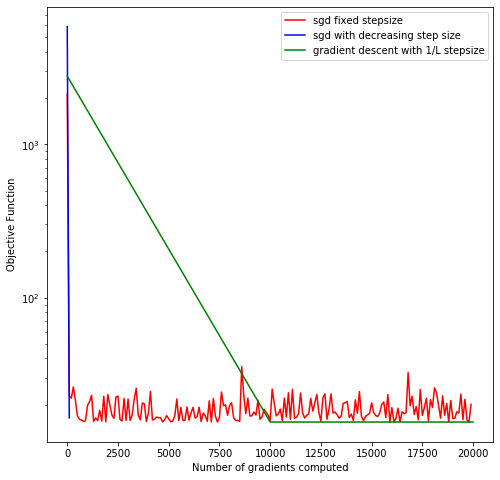

In [16]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of gradients computed')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(0,len(sgd_objectives),100),
         sgd_objectives[0:20000:100],'r', label='sgd fixed stepsize')
plt.plot(range(0,len(sgd_objectives_dec_gamma),100),
         sgd_objectives_dec_gamma[0:20000:100],'b', label='sgd with decreasing step size')
plt.plot(range(0,len(gradient_objectives)*10000,10000),
         gradient_objectives,'g', label='gradient descent with 1/L stepsize')
plt.legend(loc='upper right')
plt.show()

# Loading more complex data
The data is taken from https://archive.ics.uci.edu/ml/datasets/Concrete+Compressive+Strength 

In [22]:
data = np.loadtxt("Concrete_Data.csv",delimiter=",")

A = data[:,:-1]
b = data[:,-1]
A, mean_A, std_A = standardize(A)

In [23]:
b.shape, A.shape

((1030,), (1030, 8))

# Running stochastic gradient descent

Test your SGD algorithm on the new dataset. Try different learning rates.

In [24]:
max_iters = 4000

gamma = 0.001

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
sgd_objectives, sgd_xs = stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0000/3999): objective =     780.59
SGD(0001/3999): objective =     780.80
SGD(0002/3999): objective =     780.96
SGD(0003/3999): objective =     780.48
SGD(0004/3999): objective =     780.80
SGD(0005/3999): objective =     781.00
SGD(0006/3999): objective =     780.68
SGD(0007/3999): objective =     780.66
SGD(0008/3999): objective =     780.64
SGD(0009/3999): objective =     779.18
SGD(0010/3999): objective =     778.96
SGD(0011/3999): objective =     777.87
SGD(0012/3999): objective =     777.25
SGD(0013/3999): objective =     777.49
SGD(0014/3999): objective =     776.22
SGD(0015/3999): objective =     776.40
SGD(0016/3999): objective =     776.16
SGD(0017/3999): objective =     776.30
SGD(0018/3999): objective =     776.49
SGD(0019/3999): objective =     776.64
SGD(0020/3999): objective =     776.77
SGD(0021/3999): objective =     775.67
SGD(0022/3999): objective =     773.70
SGD(0023/3999): objective =     773.28
SGD(0024/3999): objective =     773.40
SGD(0025/3999): objective

SGD(0652/3999): objective =     715.26
SGD(0653/3999): objective =     714.76
SGD(0654/3999): objective =     714.99
SGD(0655/3999): objective =     715.04
SGD(0656/3999): objective =     714.92
SGD(0657/3999): objective =     715.09
SGD(0658/3999): objective =     714.77
SGD(0659/3999): objective =     714.90
SGD(0660/3999): objective =     715.13
SGD(0661/3999): objective =     714.84
SGD(0662/3999): objective =     714.95
SGD(0663/3999): objective =     715.14
SGD(0664/3999): objective =     715.17
SGD(0665/3999): objective =     715.27
SGD(0666/3999): objective =     715.37
SGD(0667/3999): objective =     715.46
SGD(0668/3999): objective =     715.45
SGD(0669/3999): objective =     715.27
SGD(0670/3999): objective =     715.11
SGD(0671/3999): objective =     715.16
SGD(0672/3999): objective =     715.11
SGD(0673/3999): objective =     715.03
SGD(0674/3999): objective =     714.72
SGD(0675/3999): objective =     714.41
SGD(0676/3999): objective =     714.64
SGD(0677/3999): objective

SGD(1343/3999): objective =     713.52
SGD(1344/3999): objective =     713.64
SGD(1345/3999): objective =     713.81
SGD(1346/3999): objective =     713.12
SGD(1347/3999): objective =     713.38
SGD(1348/3999): objective =     713.55
SGD(1349/3999): objective =     713.61
SGD(1350/3999): objective =     713.77
SGD(1351/3999): objective =     713.19
SGD(1352/3999): objective =     713.23
SGD(1353/3999): objective =     713.58
SGD(1354/3999): objective =     713.68
SGD(1355/3999): objective =     713.68
SGD(1356/3999): objective =     713.95
SGD(1357/3999): objective =     713.88
SGD(1358/3999): objective =     713.98
SGD(1359/3999): objective =     714.10
SGD(1360/3999): objective =     713.84
SGD(1361/3999): objective =     712.84
SGD(1362/3999): objective =     712.98
SGD(1363/3999): objective =     712.21
SGD(1364/3999): objective =     711.89
SGD(1365/3999): objective =     712.02
SGD(1366/3999): objective =     711.70
SGD(1367/3999): objective =     711.71
SGD(1368/3999): objective

SGD(2053/3999): objective =     701.03
SGD(2054/3999): objective =     700.90
SGD(2055/3999): objective =     700.94
SGD(2056/3999): objective =     701.02
SGD(2057/3999): objective =     701.15
SGD(2058/3999): objective =     701.17
SGD(2059/3999): objective =     701.27
SGD(2060/3999): objective =     701.32
SGD(2061/3999): objective =     701.44
SGD(2062/3999): objective =     701.48
SGD(2063/3999): objective =     701.33
SGD(2064/3999): objective =     701.31
SGD(2065/3999): objective =     701.28
SGD(2066/3999): objective =     701.21
SGD(2067/3999): objective =     701.23
SGD(2068/3999): objective =     701.09
SGD(2069/3999): objective =     701.15
SGD(2070/3999): objective =     701.31
SGD(2071/3999): objective =     701.32
SGD(2072/3999): objective =     701.37
SGD(2073/3999): objective =     701.24
SGD(2074/3999): objective =     701.23
SGD(2075/3999): objective =     701.06
SGD(2076/3999): objective =     700.98
SGD(2077/3999): objective =     701.10
SGD(2078/3999): objective

SGD(2777/3999): objective =     700.47
SGD(2778/3999): objective =     700.60
SGD(2779/3999): objective =     700.68
SGD(2780/3999): objective =     700.72
SGD(2781/3999): objective =     700.82
SGD(2782/3999): objective =     700.99
SGD(2783/3999): objective =     701.06
SGD(2784/3999): objective =     701.03
SGD(2785/3999): objective =     700.91
SGD(2786/3999): objective =     700.97
SGD(2787/3999): objective =     701.02
SGD(2788/3999): objective =     700.93
SGD(2789/3999): objective =     700.88
SGD(2790/3999): objective =     700.80
SGD(2791/3999): objective =     700.85
SGD(2792/3999): objective =     700.99
SGD(2793/3999): objective =     701.09
SGD(2794/3999): objective =     701.10
SGD(2795/3999): objective =     700.93
SGD(2796/3999): objective =     700.85
SGD(2797/3999): objective =     700.75
SGD(2798/3999): objective =     700.63
SGD(2799/3999): objective =     700.54
SGD(2800/3999): objective =     700.48
SGD(2801/3999): objective =     700.49
SGD(2802/3999): objective

SGD(3525/3999): objective =     699.79
SGD(3526/3999): objective =     699.83
SGD(3527/3999): objective =     699.86
SGD(3528/3999): objective =     699.68
SGD(3529/3999): objective =     699.71
SGD(3530/3999): objective =     699.72
SGD(3531/3999): objective =     699.75
SGD(3532/3999): objective =     699.76
SGD(3533/3999): objective =     699.85
SGD(3534/3999): objective =     699.92
SGD(3535/3999): objective =     699.73
SGD(3536/3999): objective =     699.91
SGD(3537/3999): objective =     699.85
SGD(3538/3999): objective =     700.09
SGD(3539/3999): objective =     699.62
SGD(3540/3999): objective =     699.70
SGD(3541/3999): objective =     699.57
SGD(3542/3999): objective =     699.82
SGD(3543/3999): objective =     699.80
SGD(3544/3999): objective =     699.80
SGD(3545/3999): objective =     699.91
SGD(3546/3999): objective =     700.05
SGD(3547/3999): objective =     699.95
SGD(3548/3999): objective =     699.80
SGD(3549/3999): objective =     699.79
SGD(3550/3999): objective

# Plotting the Evolution of the Objective Function

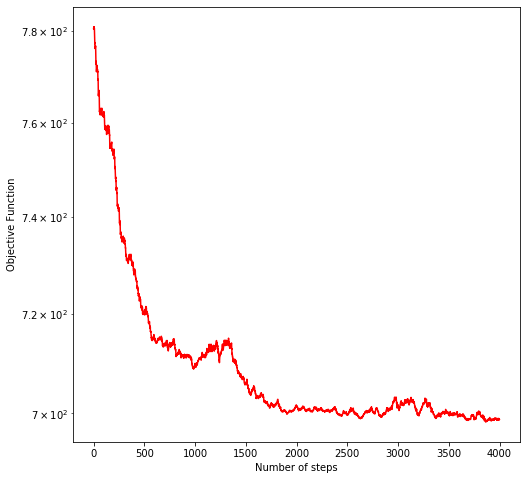

In [25]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(sgd_objectives)), sgd_objectives,'r')

plt.show()

# Projected Stochastic Gradient Descant

To avoid $x$ becoming too big, we can perform constrained optimization by projecting x onto an $\text{L}_2$ ball at each iteration, thus limiting the norm of $x$.

Fill in the `projection` function below, which projects x onto an L2-ball:
(make sure the optimum is inside the l2-ball by choosing an appropriate radius)

In [26]:
l2_ball_radius = 100  # choose an appropriate radius
def projection(x):
    """project x onto an l2-ball"""
    norm = np.linalg.norm(x) 
    if norm > l2_ball_radius:
        x = x * (l2_ball_radius / norm)
    return x

Fill in the `projected_stochastic_gradient_descent` function below:<br>
(Hint: it is the same as stochastic_gradient_descent but with an extra step in the loop)

In [27]:
def projected_stochastic_gradient_descent(
        targets_b, 
        data_A, 
        initial_x, 
        batch_size, 
        max_iters, 
        initial_learning_rate,
        decreasing_learning_rate=False, 
        projection_fn=lambda x: x):

    """Projected gradient descent."""
    xs = []  # parameters after each update 
    objectives = []  # loss values after each update
    x = initial_x
    
    for iteration in range(max_iters):
        grad = stochastic_gradient(targets_b, data_A, x, batch_size=batch_size)
        if decreasing_learning_rate:
            lr = initial_learning_rate / (iteration + 1)
        else:
            lr = initial_learning_rate
            
        # update x through the stochastic gradient update
        x -= lr * grad
        
        # project onto the subset
        x = projection_fn(x)
            
        # store x and objective
        xs.append(x.copy())
        objective = full_objective(targets_b, data_A, x)
        objectives.append(objective)

        print("SGD({bi}/{ti}): objective={l}".format(
              bi=iteration, ti=max_iters - 1, l=objective))
    return objectives, xs

Test your projected SGD function

In [28]:
max_iters = 4000

gamma = 0.001

batch_size = 1

# Initialization
x_initial = np.zeros(A.shape[1])

# Start SGD.
start_time = datetime.datetime.now()
psgd_objectives, psgd_xs = projected_stochastic_gradient_descent(
    b, A, x_initial, batch_size, max_iters, gamma,
    projection_fn=projection)
end_time = datetime.datetime.now()

# Print result
exection_time = (end_time - start_time).total_seconds()
print("SGD: execution time={t:.3f} seconds".format(t=exection_time))

SGD(0/3999): objective=781.0598093256633
SGD(1/3999): objective=781.2297000879304
SGD(2/3999): objective=781.4296548354164
SGD(3/3999): objective=781.5047168911066
SGD(4/3999): objective=780.3228807282269
SGD(5/3999): objective=780.2857372227674
SGD(6/3999): objective=780.1307353972323
SGD(7/3999): objective=780.2130809332974
SGD(8/3999): objective=780.4718174356078
SGD(9/3999): objective=780.8889660124057
SGD(10/3999): objective=779.0485800917791
SGD(11/3999): objective=778.5104300744027
SGD(12/3999): objective=778.0369089487679
SGD(13/3999): objective=777.2788896362537
SGD(14/3999): objective=776.7477601717454
SGD(15/3999): objective=776.9959214080113
SGD(16/3999): objective=777.0707177865385
SGD(17/3999): objective=775.115958401601
SGD(18/3999): objective=773.9410355513168
SGD(19/3999): objective=772.0732848243715
SGD(20/3999): objective=772.1979172152995
SGD(21/3999): objective=772.4415166040495
SGD(22/3999): objective=772.7303875636679
SGD(23/3999): objective=772.8296705925907
SGD

SGD(627/3999): objective=724.8494337574341
SGD(628/3999): objective=724.4925606434301
SGD(629/3999): objective=724.5695283762851
SGD(630/3999): objective=724.4877556758632
SGD(631/3999): objective=724.613417745572
SGD(632/3999): objective=724.7293842596408
SGD(633/3999): objective=724.8399886122294
SGD(634/3999): objective=724.9249737615194
SGD(635/3999): objective=724.8681262335315
SGD(636/3999): objective=723.9741971329664
SGD(637/3999): objective=724.1233457464175
SGD(638/3999): objective=724.3272299841275
SGD(639/3999): objective=723.3256999839226
SGD(640/3999): objective=723.313004538371
SGD(641/3999): objective=723.5483008210151
SGD(642/3999): objective=723.5777082304653
SGD(643/3999): objective=723.3876709250948
SGD(644/3999): objective=722.9495311659912
SGD(645/3999): objective=723.0092552985275
SGD(646/3999): objective=723.1736113990086
SGD(647/3999): objective=722.8498921231032
SGD(648/3999): objective=722.583832773116
SGD(649/3999): objective=722.4466132506373
SGD(650/3999):

SGD(1256/3999): objective=706.2667542147219
SGD(1257/3999): objective=706.4036978406451
SGD(1258/3999): objective=706.4436938630637
SGD(1259/3999): objective=706.3445263314745
SGD(1260/3999): objective=706.2482829515511
SGD(1261/3999): objective=706.2514797834643
SGD(1262/3999): objective=706.240637651518
SGD(1263/3999): objective=706.386320950081
SGD(1264/3999): objective=706.1521102249318
SGD(1265/3999): objective=705.9758815541095
SGD(1266/3999): objective=706.0533142661991
SGD(1267/3999): objective=705.9165386545976
SGD(1268/3999): objective=705.688850428265
SGD(1269/3999): objective=705.624158777238
SGD(1270/3999): objective=705.6979036677344
SGD(1271/3999): objective=705.360515596625
SGD(1272/3999): objective=705.1227988259
SGD(1273/3999): objective=705.3055596245023
SGD(1274/3999): objective=705.3392959122295
SGD(1275/3999): objective=705.3646427229671
SGD(1276/3999): objective=705.5218004622432
SGD(1277/3999): objective=705.5047340853524
SGD(1278/3999): objective=705.6269068943

SGD(1945/3999): objective=701.0787903883573
SGD(1946/3999): objective=700.8379968465373
SGD(1947/3999): objective=700.8123441627981
SGD(1948/3999): objective=700.9574296167733
SGD(1949/3999): objective=700.9943793503074
SGD(1950/3999): objective=701.1357973875972
SGD(1951/3999): objective=701.3584539170962
SGD(1952/3999): objective=701.4514194603817
SGD(1953/3999): objective=701.4728457240648
SGD(1954/3999): objective=701.2648279485068
SGD(1955/3999): objective=701.4674803785638
SGD(1956/3999): objective=701.3613855563951
SGD(1957/3999): objective=701.2320558969187
SGD(1958/3999): objective=700.9773466426482
SGD(1959/3999): objective=700.7446191120067
SGD(1960/3999): objective=700.6751172644688
SGD(1961/3999): objective=700.6384050830204
SGD(1962/3999): objective=700.4590441768006
SGD(1963/3999): objective=700.5529182013929
SGD(1964/3999): objective=700.6806191935372
SGD(1965/3999): objective=700.557226700021
SGD(1966/3999): objective=700.6151905223151
SGD(1967/3999): objective=700.552

SGD(2534/3999): objective=700.2355999721811
SGD(2535/3999): objective=700.2728307893095
SGD(2536/3999): objective=700.3362978857086
SGD(2537/3999): objective=700.3787695146993
SGD(2538/3999): objective=700.5482295220489
SGD(2539/3999): objective=700.7671989729228
SGD(2540/3999): objective=700.4516938812111
SGD(2541/3999): objective=700.4755877521976
SGD(2542/3999): objective=700.5322463711362
SGD(2543/3999): objective=700.5078187796005
SGD(2544/3999): objective=700.4805317646164
SGD(2545/3999): objective=700.5216379049824
SGD(2546/3999): objective=700.5924857767418
SGD(2547/3999): objective=700.740405585282
SGD(2548/3999): objective=700.6992366071212
SGD(2549/3999): objective=700.6127101089397
SGD(2550/3999): objective=700.5614907262685
SGD(2551/3999): objective=700.5104191684956
SGD(2552/3999): objective=700.4891791061501
SGD(2553/3999): objective=700.4861319593234
SGD(2554/3999): objective=700.5376842784553
SGD(2555/3999): objective=700.4769621224011
SGD(2556/3999): objective=700.466

SGD(3183/3999): objective=700.4107125768902
SGD(3184/3999): objective=700.4138673002461
SGD(3185/3999): objective=700.1562375664834
SGD(3186/3999): objective=700.0770480303772
SGD(3187/3999): objective=699.9842533175124
SGD(3188/3999): objective=699.8386884747157
SGD(3189/3999): objective=699.7727668456006
SGD(3190/3999): objective=699.7934306944783
SGD(3191/3999): objective=699.6935664505598
SGD(3192/3999): objective=699.634562148216
SGD(3193/3999): objective=699.705179876819
SGD(3194/3999): objective=699.6828756036259
SGD(3195/3999): objective=699.7037926956674
SGD(3196/3999): objective=699.8749178249436
SGD(3197/3999): objective=699.8472201194494
SGD(3198/3999): objective=699.8818303345452
SGD(3199/3999): objective=699.8739660178011
SGD(3200/3999): objective=699.9309057384866
SGD(3201/3999): objective=699.9644230121313
SGD(3202/3999): objective=699.8934193120543
SGD(3203/3999): objective=700.0032663613687
SGD(3204/3999): objective=700.0662439777662
SGD(3205/3999): objective=699.9764

SGD(3763/3999): objective=699.3878115345543
SGD(3764/3999): objective=699.5160734192444
SGD(3765/3999): objective=699.6230102479248
SGD(3766/3999): objective=699.6380295677993
SGD(3767/3999): objective=699.6407582500094
SGD(3768/3999): objective=699.7868282611951
SGD(3769/3999): objective=699.8864636948929
SGD(3770/3999): objective=700.0935439324223
SGD(3771/3999): objective=700.1250847908851
SGD(3772/3999): objective=700.0032988279216
SGD(3773/3999): objective=700.0007425222179
SGD(3774/3999): objective=700.0271816795135
SGD(3775/3999): objective=700.1137614070342
SGD(3776/3999): objective=700.2329991821379
SGD(3777/3999): objective=700.1263206878995
SGD(3778/3999): objective=700.1866374629373
SGD(3779/3999): objective=700.1811193215804
SGD(3780/3999): objective=700.3330732306217
SGD(3781/3999): objective=700.3947868405122
SGD(3782/3999): objective=700.4869046128603
SGD(3783/3999): objective=700.6357079697983
SGD(3784/3999): objective=700.7018482438278
SGD(3785/3999): objective=700.78

Plot the error

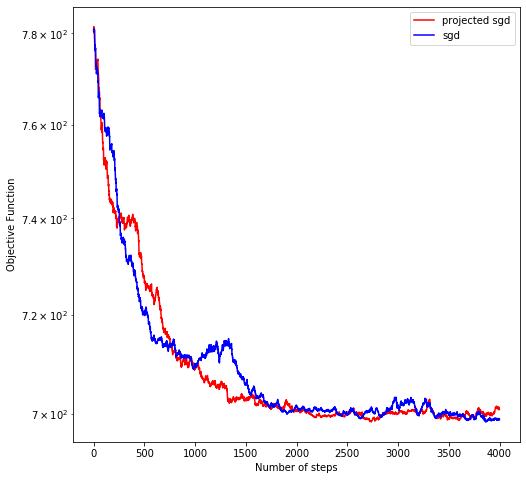

In [29]:
plt.figure(figsize=(8, 8))
plt.xlabel('Number of steps')
plt.ylabel('Objective Function')
plt.yscale("log")
plt.plot(range(len(psgd_objectives)), psgd_objectives,'r', label='projected sgd')
plt.plot(range(len(sgd_objectives)), sgd_objectives,'b', label='sgd')
plt.legend(loc='upper right')
plt.show()